**1. Importing libraries**

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import optlib.optical as opt

np.seterr(divide='ignore', invalid='ignore')

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
plt.rcParams['font.size'] = 16
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib notebook

**2. Path to the directory containing Henke ionisation data (download from https://henke.lbl.gov/optical_constants/asf.html)**

In [2]:
xraypath = '/Users/olgaridzel/Research/optical-data-fit/sf/'

***FITTING PART***

**Al**

In [3]:
# diimfp fit with alpha = 1 as initial
# A = [131.016, 60.718, 109.935]
# gamma = [0.919, 99.059, 48.391]
# omega = [10.028, 48.137, 43.035]
# alpha = 0.99

# diimfp fit with alpha = 0 as initial
A = [111.679, 97.146, 92.833]
gamma = [0.796, 98.962, 50.909]
omega = [10.945, 56.767, 33.395]
alpha = 0.09663535221663536

M = 26.981538 # Molar weight
rho = 2.70 # g/cm3

oscillators = opt.Oscillators('Drude', A, gamma, omega, alpha = alpha)
composition = opt.Composition(['al'], [1])
eloss = opt.linspace(opt.machine_eps,100,0.1)
q = 0

al_drude = opt.Material('Al', oscillators, composition, eloss, q, xraypath)
al_drude.Eg = 0
al_drude.Ef = 11.36
al_drude.atomic_density = rho * opt.N_Avogadro / M *1e-24
al_drude.static_refractive_index = 1.1563
al_drude.Z = 13
al_drude.use_henke_for_ne = True
al_drude.use_KK_constraint = True

fsum = al_drude.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(al_drude.Z))

kksum = al_drude.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 11.96094161119878
Z = 13
KKSum = 0.5296155426961399


Starting optimisation...
Electron density = 0.21877703476149593
found minimum after 1001 evaluations
minimum value =  0.020731788540190244
result code =  5
Starting optimisation...
Electron density = 0.21877703476149593
found minimum after 1000 evaluations
minimum value =  0.004905690004534381
result code =  5
FSum = 11.631682978004328
Z = 13
KKSum = 0.5796145255107987
A = [128.267, 101.618, 71.787]
gamma = [0.31, 98.82, 84.655]
omega = [10.106, 95.874, 63.288]
alpha = 0.15511031275059461


<IPython.core.display.Javascript object>


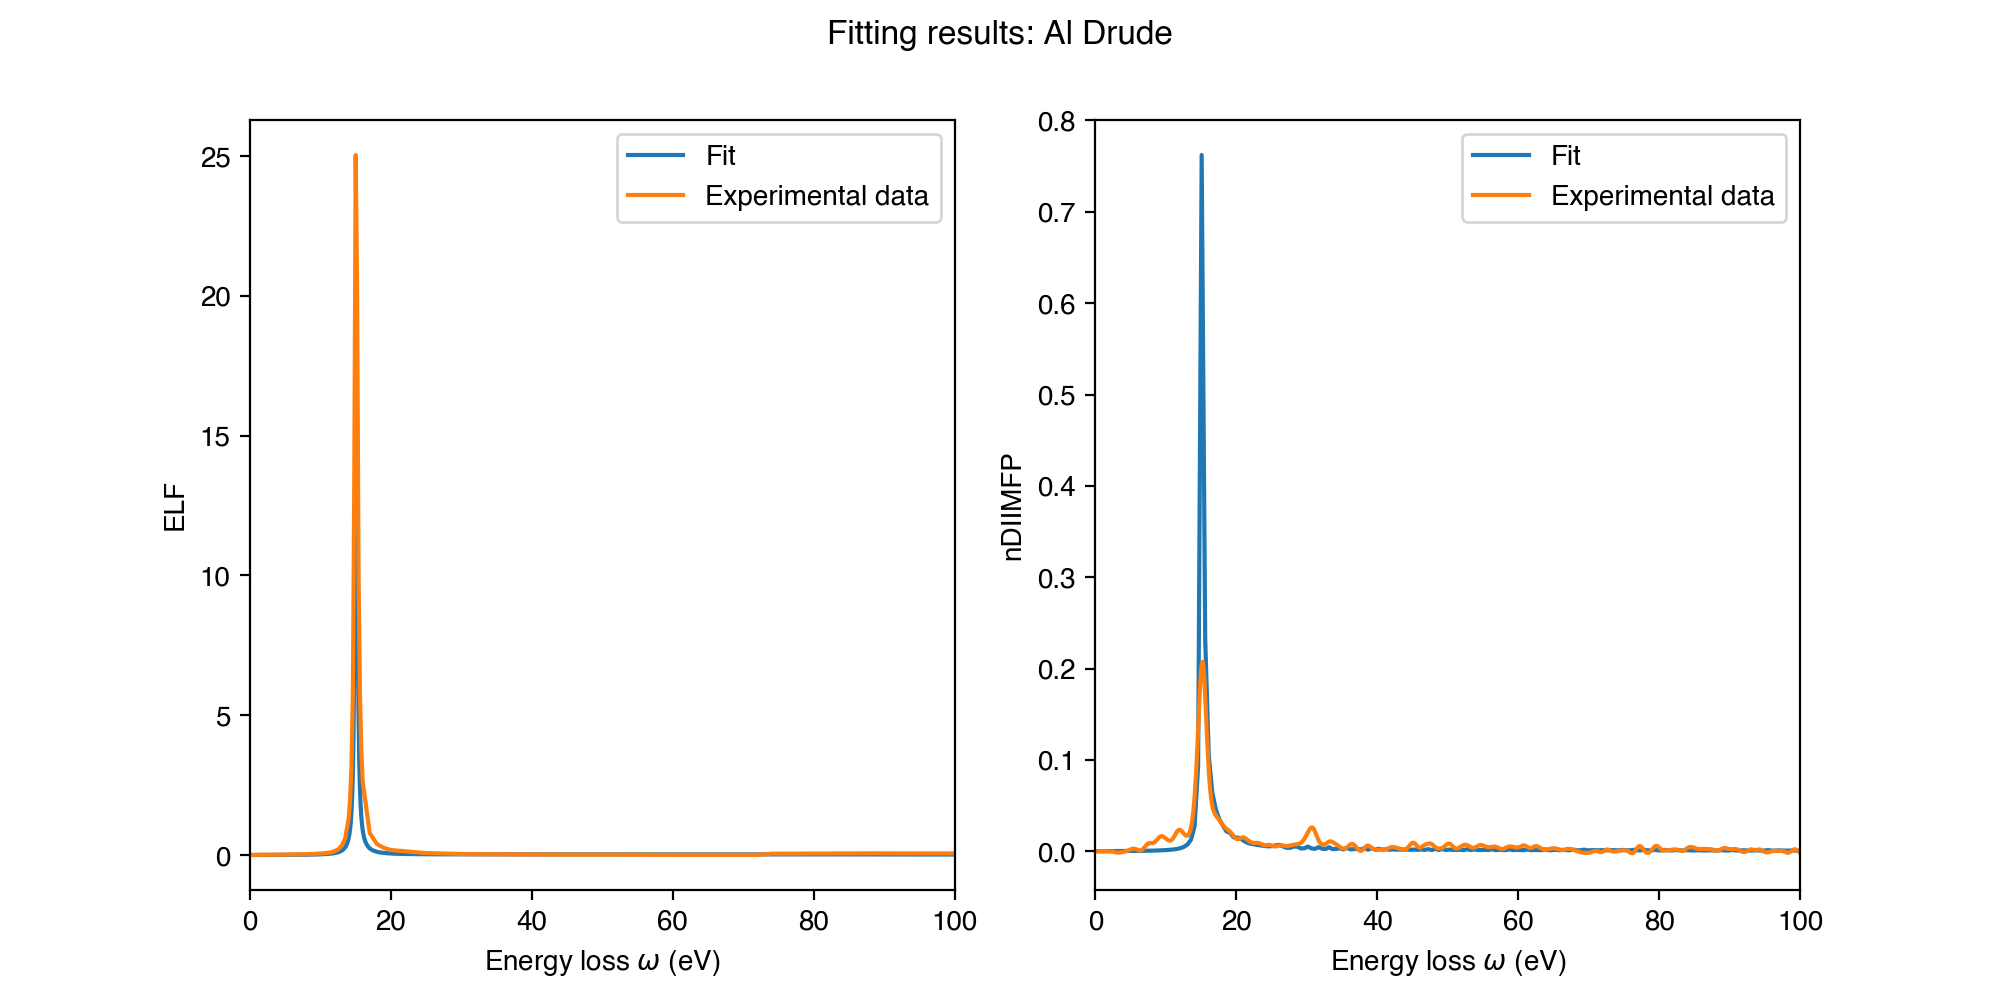

In [4]:
fd = np.loadtxt('Al/al.diel')
x_exp_elf = fd[:,0]
y_exp_elf = fd[:,3]

exp_data = np.loadtxt('/Users/olgaridzel/Research/olga-optical-data/MATLAB/diimfp/wolga/al.wo', usecols = (0,1,2))
x_exp_ndiimfp = exp_data[:,0]
y_exp_ndiimfp = exp_data[:,1]

exp_data = opt.exp_data()
exp_data.x_elf = x_exp_elf
exp_data.y_elf = y_exp_elf
exp_data.x_ndiimfp = x_exp_ndiimfp
exp_data.y_ndiimfp = y_exp_ndiimfp

opt_ = opt.OptFit(al_drude, exp_data, 1600, n_q = 10)
result = opt_.runOptimisation(0.95, 0.05, maxeval = 1000, xtol_rel = 1e-4, isGlobal = True)
oscOptimised = opt_.vec2Struct(result)

opt_ = opt.OptFit(oscOptimised, exp_data, 1600, n_q = 10)
result = opt_.runOptimisation(0.95, 0.05, maxeval = 1000, xtol_rel = 1e-4, isGlobal = False)
oscOptimised = opt_.vec2Struct(result)

fsum = oscOptimised.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluateKKsum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')
print(f'alpha = {oscOptimised.oscillators.alpha}')
# print()
# print(f'osc.A = [{" ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}];')
# print(f'osc.G = [{" ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}];')
# print(f'osc.Om = [{" ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}];')

# oscOptimised = al_drude
oscOptimised.calculateELF()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(oscOptimised.eloss,oscOptimised.ELF,label='Fit')
axs[0].plot(exp_data.x_elf,exp_data.y_elf,label='Experimental data')
axs[0].set_xlabel('Energy loss $\omega$ (eV)')
axs[0].set_ylabel('ELF')
axs[0].legend()
axs[0].set_xlim(0,100)

oscOptimised.calculateDIIMFP(3400)
axs[1].plot(oscOptimised.DIIMFP_E,oscOptimised.DIIMFP,label='Fit')
axs[1].plot(exp_data.x_ndiimfp,exp_data.y_ndiimfp,label='Experimental data')
axs[1].set_xlabel('Energy loss $\omega$ (eV)')
axs[1].set_ylabel('nDIIMFP')
axs[1].legend()
axs[1].set_xlim(0,100)

fig.suptitle(f'Fitting results: {oscOptimised.name} {oscOptimised.oscillators.model}')
plt.show()

In [6]:
# A = [0.54, 0.33, 0.1, 0.03, 0.02]
# gamma = [0.46, 0.5, 1.49, 6.75, 30.49]
# omega = [14.99, 15.21, 16.13, 21.56, 91.69]

A = [0.03, 0.124, 0.057, 0.023, 0.018]
gamma = [0.468, 0.53, 1.516, 6.175, 47.302]
omega = [15.249, 14.849, 14.868, 22.499, 167.293]

M = 26.981538 # Molar weight
rho = 2.70 # g/cm3

oscillators = opt.Oscillators('Mermin', A, gamma, omega, alpha = 1)
composition = opt.Composition(['al'], [1])
eloss = opt.linspace(opt.machine_eps,100,0.1)
q = 0.01

al_m = opt.Material('Al', oscillators, composition, eloss, q, xraypath)
al_m.Eg = 0
al_m.Ef = 11.2
al_m.atomic_density = rho * opt.N_Avogadro / M *1e-24
al_m.static_refractive_index = 1.1563
al_m.Z = 13
al_m.use_henke_for_ne = True
al_m.use_KK_constraint = False

fsum = al_m.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(al_m.Z))

kksum = al_m.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 10.192437887441848
Z = 13
KKSum = 0.2577262366885931


<IPython.core.display.Javascript object>


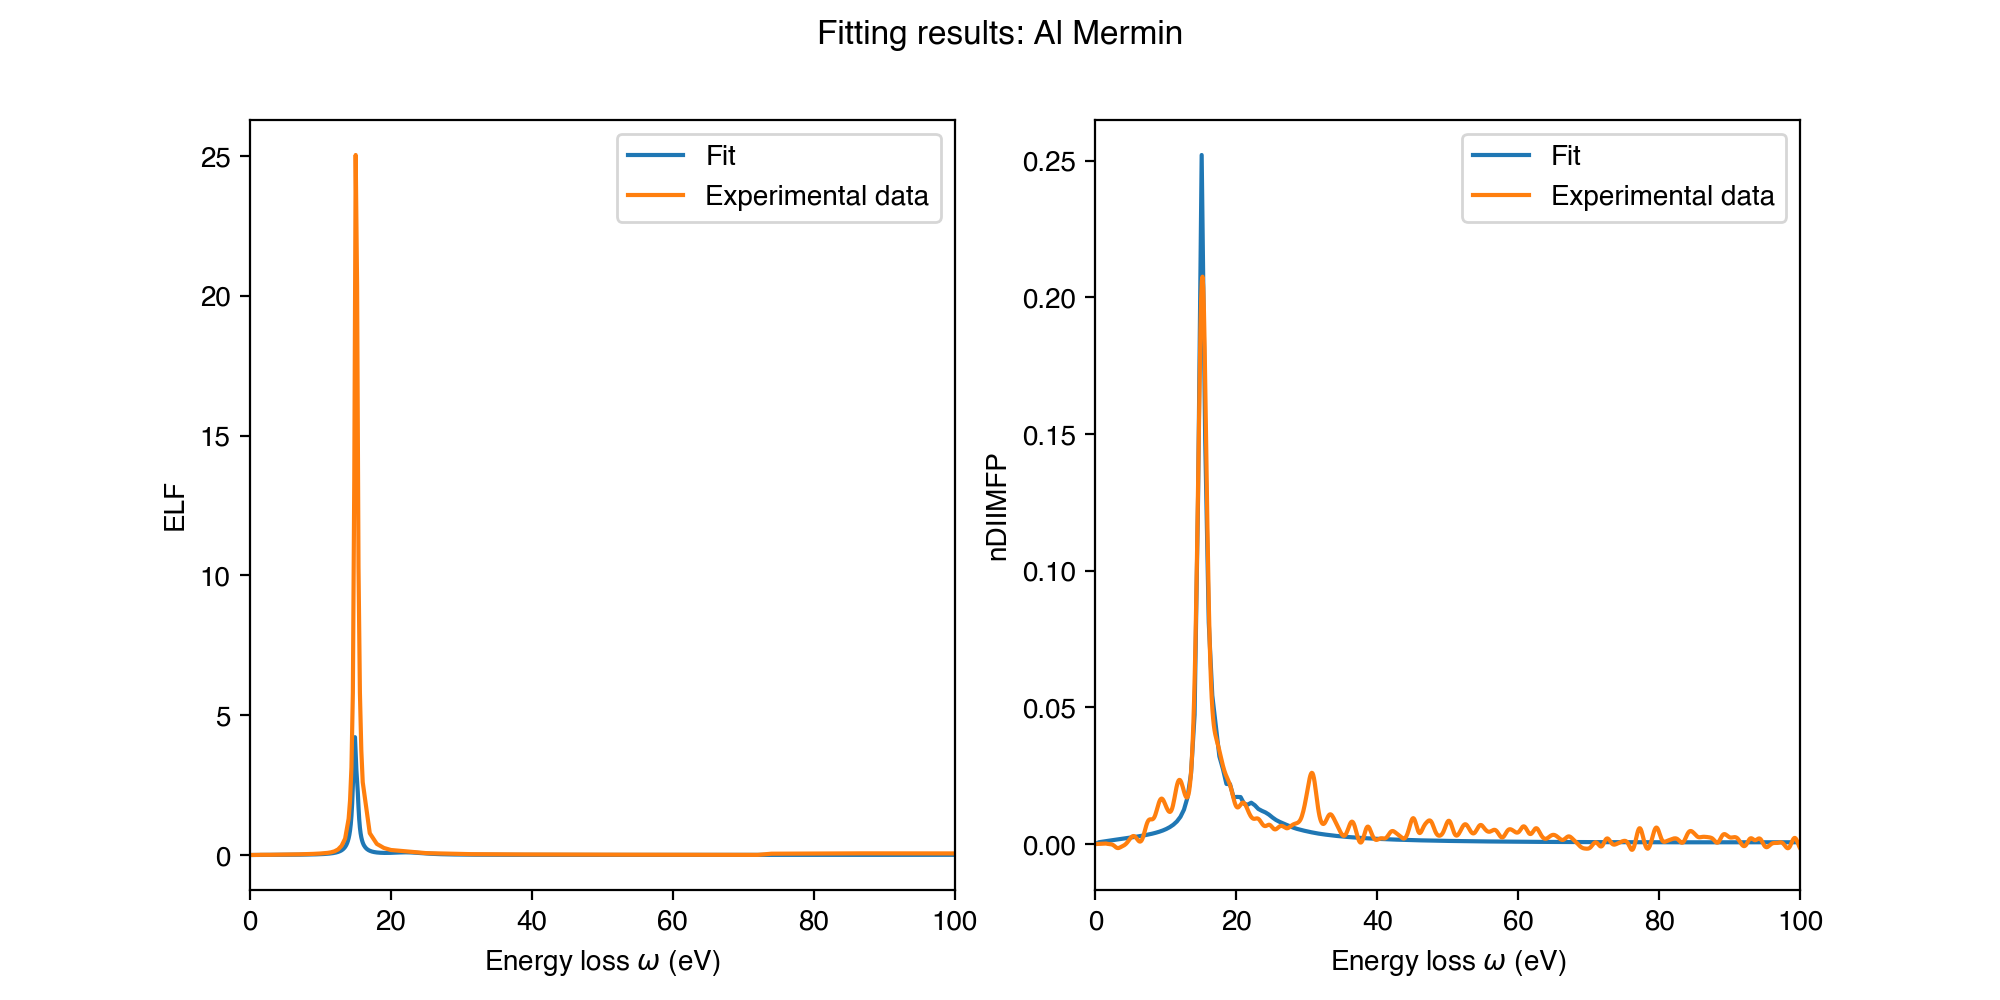

In [7]:
fd = np.loadtxt('Al/al.diel')
x_exp_elf = fd[:,0]
y_exp_elf = fd[:,3]

exp_data = np.loadtxt('/Users/olgaridzel/Research/olga-optical-data/MATLAB/diimfp/wolga/al.wo', usecols = (0,1,2))
x_exp_ndiimfp = exp_data[:,0]
y_exp_ndiimfp = exp_data[:,1]

exp_data = opt.exp_data()
exp_data.x_elf = x_exp_elf
exp_data.y_elf = y_exp_elf
exp_data.x_ndiimfp = x_exp_ndiimfp
exp_data.y_ndiimfp = y_exp_ndiimfp

# opt_ = opt.OptFit(al_m, exp_data, 1600, n_q = 10)
# result = opt_.runOptimisation('elf+ndiimfp', maxeval = 500, xtol_rel = 1e-2)
# oscOptimised = opt_.vec2Struct(result)

# fsum = oscOptimised.evaluateFsum()
# print('FSum = {}'.format(fsum))
# print('Z = {}'.format(oscOptimised.Z))

# kksum = oscOptimised.evaluateKKsum()
# print('KKSum = {}'.format(kksum))

# print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
# print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
# print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')
# print(f'alpha = {oscOptimised.oscillators.alpha}')
# print()
# print(f'osc.A = [{" ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}];')
# print(f'osc.G = [{" ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}];')
# print(f'osc.Om = [{" ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}];')

oscOptimised = al_m
oscOptimised.calculateELF()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(oscOptimised.eloss,oscOptimised.ELF,label='Fit')
axs[0].plot(exp_data.x_elf,exp_data.y_elf,label='Experimental data')
axs[0].set_xlabel('Energy loss $\omega$ (eV)')
axs[0].set_ylabel('ELF')
axs[0].legend()
axs[0].set_xlim(0,100)

oscOptimised.calculateDIIMFP(3400)
axs[1].plot(oscOptimised.DIIMFP_E,oscOptimised.DIIMFP,label='Fit')
axs[1].plot(exp_data.x_ndiimfp,exp_data.y_ndiimfp,label='Experimental data')
axs[1].set_xlabel('Energy loss $\omega$ (eV)')
axs[1].set_ylabel('nDIIMFP')
axs[1].legend()
axs[1].set_xlim(0,100)

fig.suptitle(f'Fitting results: {oscOptimised.name} {oscOptimised.oscillators.model}')
plt.show()

In [106]:
plt.figure()
al_m.eloss = np.linspace(0,1000,2000)
al_m.calculateELF()
q_list = opt.linspace(0.0, 18, 0.02)

fd = open('Al/elf.in', 'w')

for q in q_list:
    al_m.q = q
    al_m.calculateELF()
    for i in range(len(al_m.eloss)):
        fd.write(f'{al_m.eloss[i]:.8f} {al_m.ELF[i]:.8f}\n')
    fd.write(f'{q} {q}\n')
    fd.write('99999999 99999999\n')
    plt.plot(al_m.eloss, al_m.ELF)
    
plt.show()
fd.close()

**Cu**

In [5]:
A = [64, 6, 6.5, 5.5, 4, 55, 42, 172, 80, 240, 90, 85, 200, 500]
gamma = [0.3, 0.3, 0.65, 0.7, 0.7, 2.6, 4.76, 10.18, 8, 32, 30, 30, 45, 65]
omega = [0.01, 0.3, 2.5, 3.1, 3.7, 5.05, 8.93, 14.74, 25.6, 40, 55, 65, 83, 120]
alpha = 1

M = 63.546 # Molar weight
rho = 8.92 # g/cm3

oscillators = opt.Oscillators('Drude', A, gamma, omega, alpha = alpha)
composition = opt.Composition(['cu'], [1])
eloss = opt.linspace(opt.machine_eps,100,0.1)
q = 0

cu_drude = opt.Material('Cu', oscillators, composition, eloss, q, xraypath)
cu_drude.Eg = 0
cu_drude.Ef = 8.7
cu_drude.atomic_density = rho * opt.N_Avogadro / M *1e-24
cu_drude.static_refractive_index = 0.63660
cu_drude.Z = 29
cu_drude.use_henke_for_ne = True
cu_drude.use_KK_constraint = False

fsum = cu_drude.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(cu_drude.Z))

kksum = cu_drude.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 28.31908492864291
Z = 29
KKSum = 1.0109730839640119


Starting optimisation...
Electron density = 0.6697944019790132
found minimum after 1001 evaluations
minimum value =  0.0018495242482036685
result code =  5
Starting optimisation...
Electron density = 0.6697944019790132
found minimum after 1000 evaluations
minimum value =  0.0018543908731230982
result code =  5
FSum = 27.853224052274825
Z = 29
KKSum = 1.0363745201761034
A = [52.845, 3.887, 4.87, 4.122, 4.161, 2.611, 27.152, 81.152, 35.512, 244.822, 64.819, 167.344, 232.829, 0.019]
gamma = [0.61, 0.485, 1.802, 0.682, 1.021, 2.888, 8.354, 11.49, 6.703, 21.699, 25.682, 13.416, 26.143, 99.411]
omega = [0.021, 0.319, 1.81, 3.015, 5.189, 6.05, 6.55, 16.542, 26.298, 11.635, 41.511, 72.571, 53.337, 107.787]
alpha = 0.8246299009744374


<IPython.core.display.Javascript object>


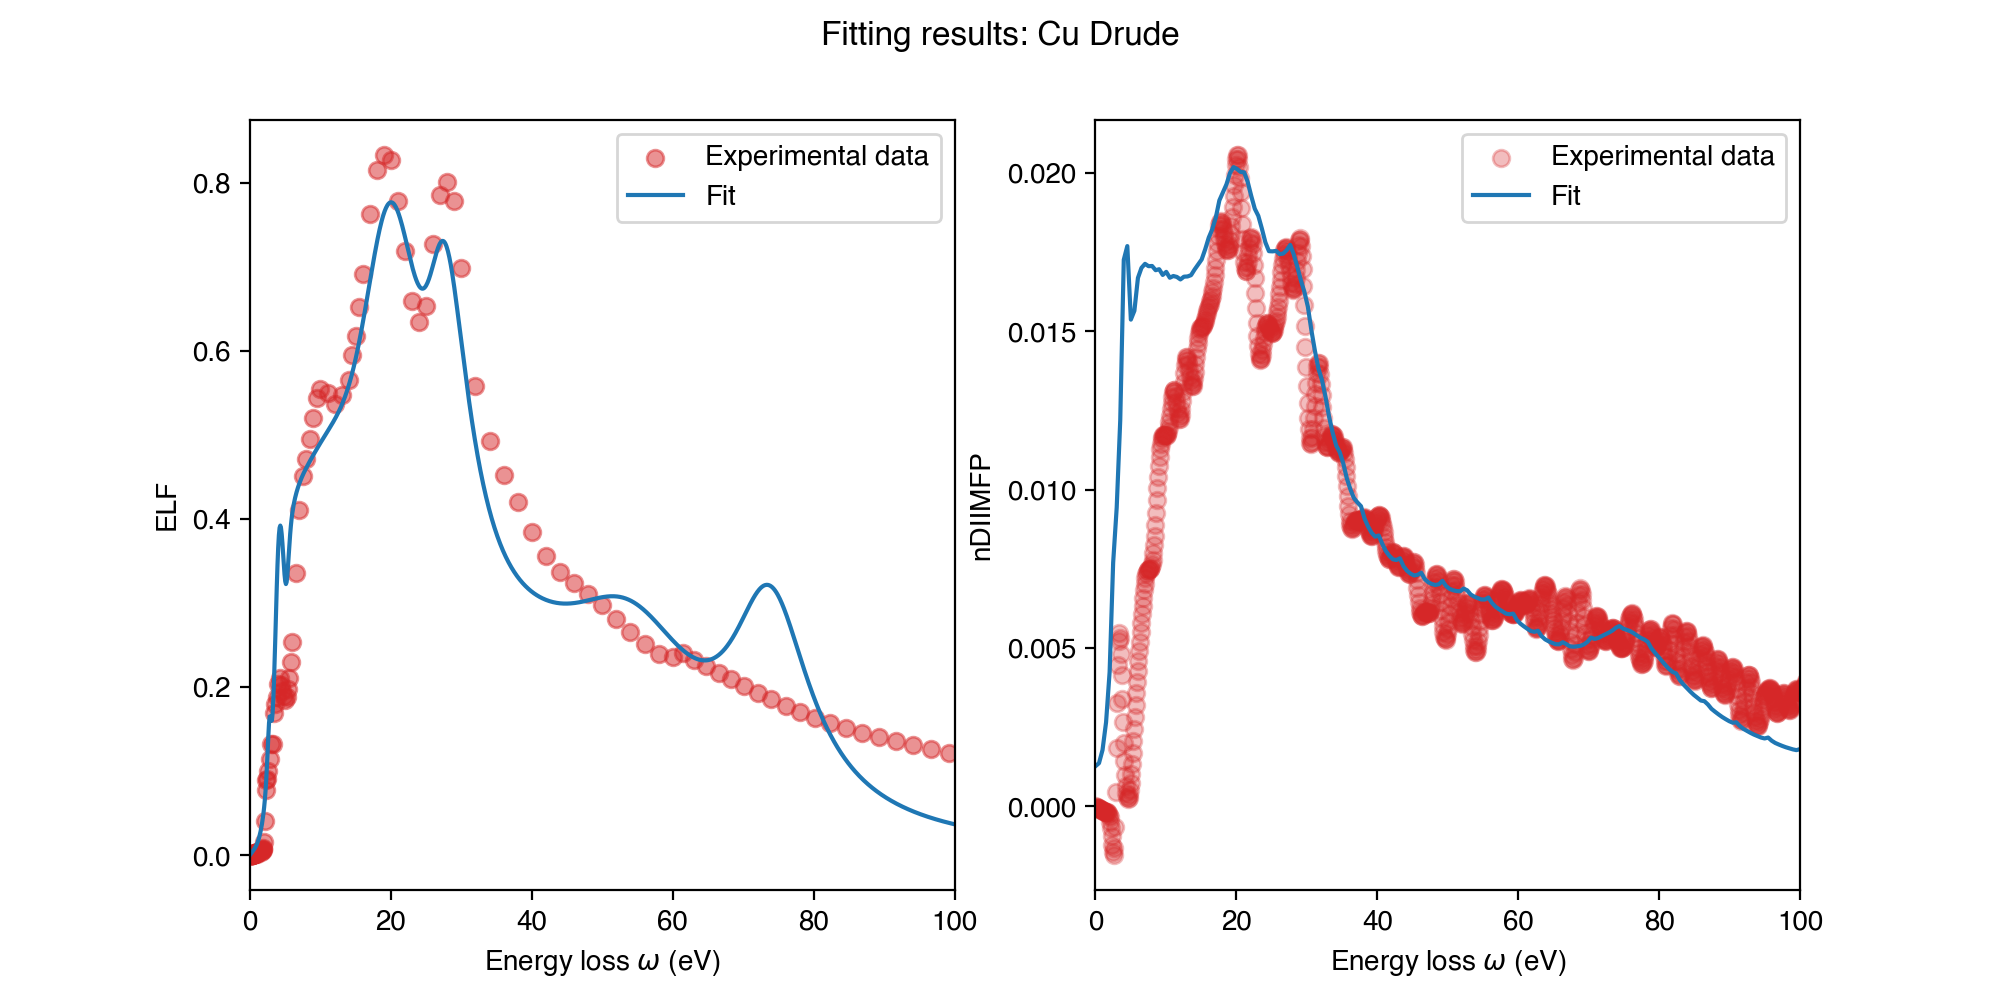

In [6]:
E0 = 3400

fd = np.loadtxt('/Users/olgaridzel/Research/PHYSDAT/opt/pal/cu.diel')
x_exp_elf = fd[:,0]
y_exp_elf = fd[:,3]

exp_data = np.loadtxt('/Users/olgaridzel/Research/olga-optical-data/MATLAB/diimfp/wolga/cu.wo', usecols = (0,1,2))
x_exp_ndiimfp = exp_data[:,0]
y_exp_ndiimfp = exp_data[:,1]

exp_data = opt.exp_data()
exp_data.x_elf = x_exp_elf
exp_data.y_elf = y_exp_elf
exp_data.x_ndiimfp = x_exp_ndiimfp
exp_data.y_ndiimfp = y_exp_ndiimfp

opt_ = opt.OptFit(cu_drude, exp_data, E0, n_q = 10)
result = opt_.runOptimisation(0.95, 0.05, maxeval = 1000, xtol_rel = 1e-4, isGlobal = True)
oscOptimised = opt_.vec2Struct(result)

opt_ = opt.OptFit(oscOptimised, exp_data, E0, n_q = 10)
result = opt_.runOptimisation(0.95, 0.05, maxeval = 1000, xtol_rel = 1e-4, isGlobal = False)
oscOptimised = opt_.vec2Struct(result)

fsum = oscOptimised.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluateKKsum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')
print(f'alpha = {oscOptimised.oscillators.alpha}')
# print()
# print(f'osc.A = [{" ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}];')
# print(f'osc.G = [{" ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}];')
# print(f'osc.Om = [{" ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}];')

# oscOptimised = cu_drude
oscOptimised.calculateELF()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].scatter(exp_data.x_elf,exp_data.y_elf,label='Experimental data', c='tab:red', alpha = 0.5)
axs[0].plot(oscOptimised.eloss,oscOptimised.ELF,label='Fit')
axs[0].set_xlabel('Energy loss $\omega$ (eV)')
axs[0].set_ylabel('ELF')
axs[0].legend()
axs[0].set_xlim(0,100)

oscOptimised.calculateDIIMFP(E0)
axs[1].scatter(exp_data.x_ndiimfp,exp_data.y_ndiimfp,label='Experimental data', c='tab:red', alpha = 0.3)
axs[1].plot(oscOptimised.DIIMFP_E,oscOptimised.DIIMFP,label='Fit')
axs[1].set_xlabel('Energy loss $\omega$ (eV)')
axs[1].set_ylabel('nDIIMFP')
axs[1].legend()
axs[1].set_xlim(0,100)

fig.suptitle(f'Fitting results: {oscOptimised.name} {oscOptimised.oscillators.model}')
plt.show()

In [5]:
A = [86.3, 19.8, 21.9, 30.2, 2.5, 157.7, 130.9, 108.6, 40, 1022.4]
gamma = [0.027, 0.5, 0.5, 1.7, 0.5, 11.3, 10.1, 68.2, 3, 55.1]
omega = [0, 1, 1, 4, 4.8, 7.2, 14.2, 16.9, 24.3, 59.4]
alpha = 1

M = 63.546 # Molar weight
rho = 8.92 # g/cm3

oscillators = opt.Oscillators('Drude', A, gamma, omega, alpha = alpha)
composition = opt.Composition(['cu'], [1])
eloss = opt.linspace(opt.machine_eps,100,0.1)
q = 0

cu_drude_lorenz = opt.Material('Cu', oscillators, composition, eloss, q, xraypath)
cu_drude_lorenz.Eg = 0
cu_drude_lorenz.Ef = 8.7
cu_drude_lorenz.atomic_density = rho * opt.N_Avogadro / M *1e-24
cu_drude_lorenz.static_refractive_index = 0.63660
cu_drude_lorenz.Z = 29
cu_drude_lorenz.use_henke_for_ne = True
cu_drude_lorenz.use_KK_constraint = True

fsum = cu_drude_lorenz.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(cu_drude_lorenz.Z))

kksum = cu_drude_lorenz.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 30.427905838669798
Z = 29
KKSum = 1.0212980597703276


Starting optimisation...
Electron density = 0.6697944019790132
found minimum after 616 evaluations
minimum value =  7.4863331801426135e-06
result code =  4
FSum = 26.982564024573897
Z = 29
KKSum = 0.9979545093558057
A = [66.984, 13.873, 16.589, 28.359, 3.475, 86.532, 105.959, 167.738, 45.081, 388.968]
gamma = [0.028, 0.221, 0.516, 2.003, 0.498, 10.359, 9.638, 83.547, 2.575, 54.16]
omega = [67.354, 1.722, 0.986, 3.845, 4.864, 8.336, 10.912, 21.281, 24.824, 37.277]
alpha = 0.9174529843734213


<IPython.core.display.Javascript object>


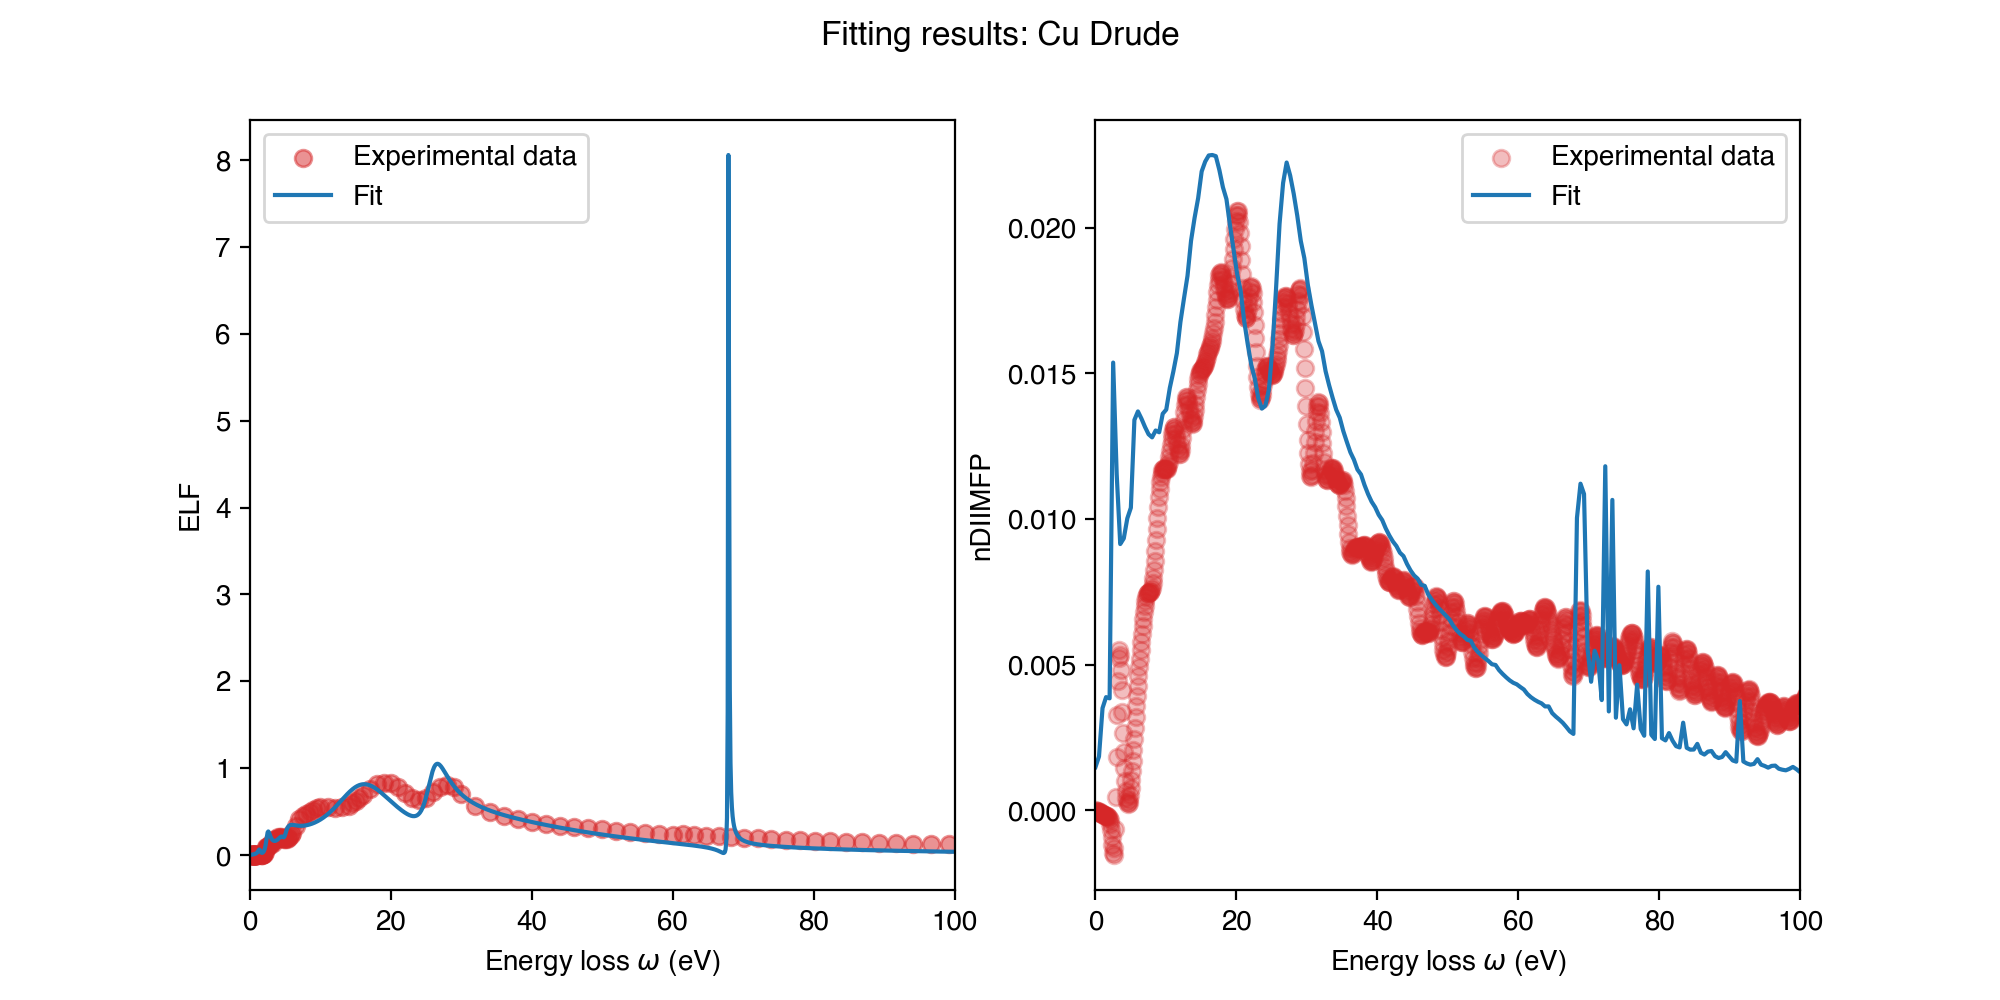

In [6]:
E0 = 3400

fd = np.loadtxt('/Users/olgaridzel/Research/PHYSDAT/opt/pal/cu.diel')
x_exp_elf = fd[:,0]
y_exp_elf = fd[:,3]

exp_data = np.loadtxt('/Users/olgaridzel/Research/olga-optical-data/MATLAB/diimfp/wolga/cu.wo', usecols = (0,1,2))
x_exp_ndiimfp = exp_data[:,0]
y_exp_ndiimfp = exp_data[:,1]

exp_data = opt.exp_data()
exp_data.x_elf = x_exp_elf
exp_data.y_elf = y_exp_elf
exp_data.x_ndiimfp = x_exp_ndiimfp
exp_data.y_ndiimfp = y_exp_ndiimfp

opt_ = opt.OptFit(cu_drude_lorenz, exp_data, E0, n_q = 10)
result = opt_.runOptimisation(1, 0.0, maxeval = 1000, xtol_rel = 1e-4, isGlobal = False)
oscOptimised = opt_.vec2Struct(result)

# opt_ = opt.OptFit(oscOptimised, exp_data, E0, n_q = 10)
# result = opt_.runOptimisation(1, 0.0, maxeval = 1000, xtol_rel = 1e-4, isGlobal = False)
# oscOptimised = opt_.vec2Struct(result)

fsum = oscOptimised.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluateKKsum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')
print(f'alpha = {oscOptimised.oscillators.alpha}')
# print()
# print(f'osc.A = [{" ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}];')
# print(f'osc.G = [{" ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}];')
# print(f'osc.Om = [{" ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}];')

# oscOptimised = cu_drude
oscOptimised.calculateELF()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].scatter(exp_data.x_elf,exp_data.y_elf,label='Experimental data', c='tab:red', alpha = 0.5)
axs[0].plot(oscOptimised.eloss,oscOptimised.ELF,label='Fit')
axs[0].set_xlabel('Energy loss $\omega$ (eV)')
axs[0].set_ylabel('ELF')
axs[0].legend()
axs[0].set_xlim(0,100)

oscOptimised.calculateDIIMFP(E0)
axs[1].scatter(exp_data.x_ndiimfp,exp_data.y_ndiimfp,label='Experimental data', c='tab:red', alpha = 0.3)
axs[1].plot(oscOptimised.DIIMFP_E,oscOptimised.DIIMFP,label='Fit')
axs[1].set_xlabel('Energy loss $\omega$ (eV)')
axs[1].set_ylabel('nDIIMFP')
axs[1].legend()
axs[1].set_xlim(0,100)

fig.suptitle(f'Fitting results: {oscOptimised.name} {oscOptimised.oscillators.model}')
plt.show()

In [104]:
A = [0.01, 0.02, 0.06, 0.11, 0.38, 0.15, 0.07, 0.05, 0.08, 0.1]
gamma = [0.69, 0.8, 2.36, 6.59, 10.82, 4.89, 40.77, 19.15, 14.12, 161.76]
omega = [3.46, 4.2, 7.54, 28.34, 19.39, 10.48, 66.56, 47.52, 36.14, 126.04]

M = 63.546 # Molar weight
rho = 8.96 # g/cm3

oscillators = opt.Oscillators('Mermin', A, gamma, omega, alpha = 0)
composition = opt.Composition(['cu'], [1])
eloss = opt.linspace(opt.machine_eps,100,0.1)
q = 0.01

cu_m = opt.Material('Cu', oscillators, composition, eloss, q, xraypath)
cu_m.Eg = 0
cu_m.Ef = 8.7
cu_m.atomic_density = rho * opt.N_Avogadro / M *1e-24
cu_m.static_refractive_index = 0.63660
cu_m.Z = 29
cu_m.use_henke_for_ne = True
cu_m.use_KK_constraint = False
cu_m.use_kk_relation = False

fsum = cu_m.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(cu_m.Z))

kksum = cu_m.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 28.26767093572482
Z = 29
KKSum = 1.030928759550817


Start optimisation
Electron density = 0.6697944019790132
FSum = 27.055386678648112
Z = 29
KKSum = 1.016907362648181
A = [54.295, 17.403, 45.489, 27.64, 5.645, 63.441, 119.789, 198.956, 35.836, 355.159]
gamma = [0.028, 0.597, 0.587, 3.009, 0.513, 7.332, 8.128, 88.104, 3.914, 43.844]
omega = [4.975, 1.41, 1.043, 3.727, 3.694, 8.571, 13.78, 35.223, 23.718, 45.567]
osc.A = [54.295 17.403 45.489 27.64 5.645 63.441 119.789 198.956 35.836 355.159];
osc.G = [0.028 0.597 0.587 3.009 0.513 7.332 8.128 88.104 3.914 43.844];
osc.Om = [4.975 1.41 1.043 3.727 3.694 8.571 13.78 35.223 23.718 45.567];


<IPython.core.display.Javascript object>


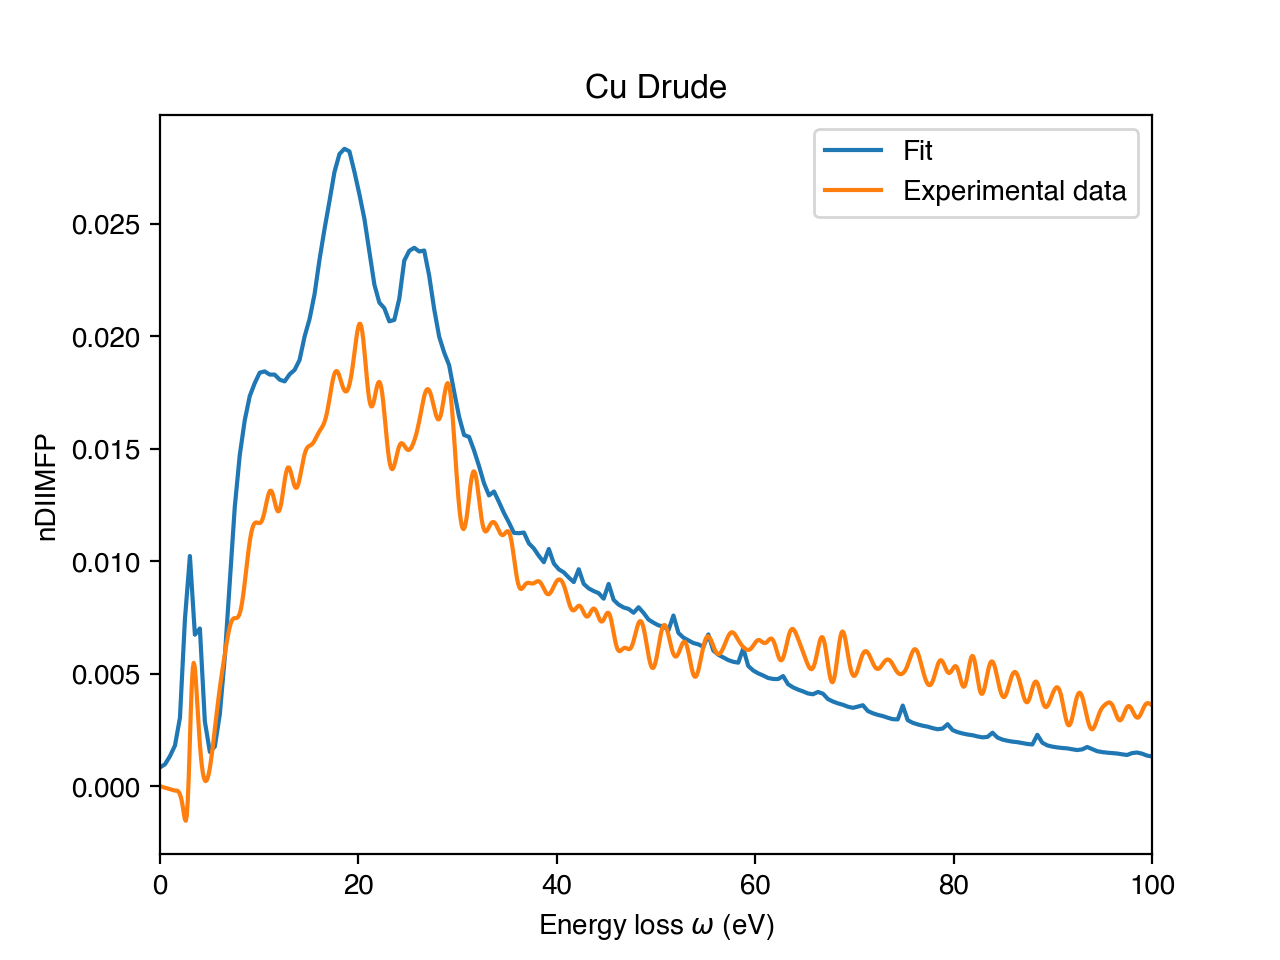

In [9]:
exp_data = np.loadtxt('/Users/olgaridzel/Research/olga-optical-data/MATLAB/diimfp/wolga/cu.wo', usecols = (0,1,2))
x_exp = exp_data[:,0]
y_exp = exp_data[:,1]

opt_ = opt.OptFit(cu_drude_lorenz, x_exp, y_exp, 3400)
result = opt_.runOptimisation('ndiimfp', maxeval = 500, xtol_rel = 1e-10)
oscOptimised = opt_.vec2Struct(result)

fsum = oscOptimised.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluateKKsum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')

print(f'osc.A = [{" ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}];')
print(f'osc.G = [{" ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}];')
print(f'osc.Om = [{" ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}];')

# oscOptimised = cu_drude_lorenz
oscOptimised.calculateDIIMFP(3400)

plt.figure()
plt.plot(oscOptimised.DIIMFP_E,oscOptimised.DIIMFP,label='Fit')
plt.plot(x_exp,y_exp,label='Experimental data')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('nDIIMFP')
plt.title(f'{oscOptimised.name} {oscOptimised.oscillators.model}')
plt.legend()
plt.xlim(0,100)
plt.show()

Metal Ef = 8.7
rel_coef 1.009991315125679
Metal Ef = 8.7
rel_coef 1.009991315125679
Metal Ef = 8.7
rel_coef 1.009991315125679


<IPython.core.display.Javascript object>


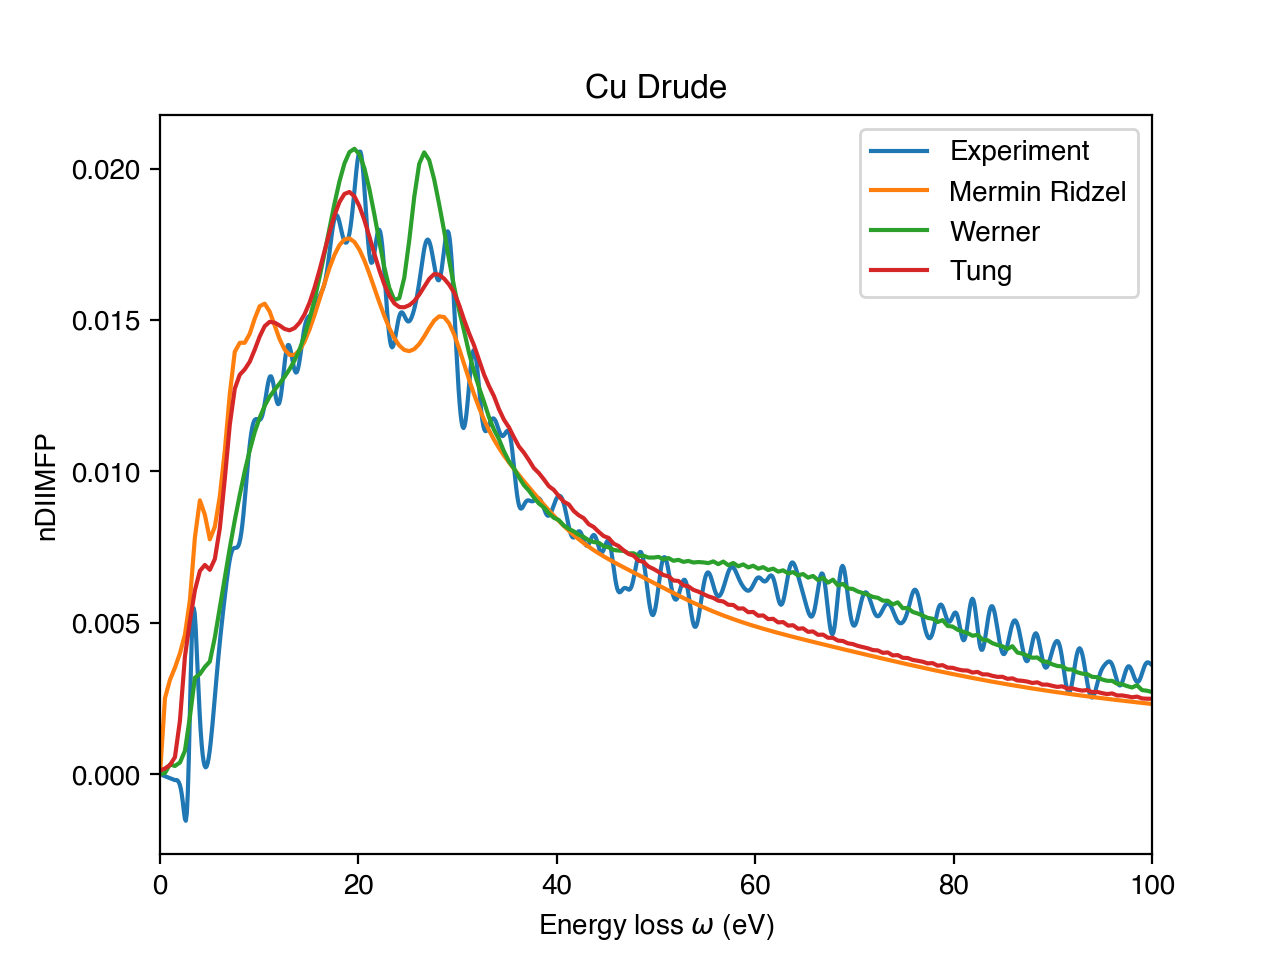

In [105]:
exp_data = np.loadtxt('/Users/olgaridzel/Research/olga-optical-data/MATLAB/diimfp/wolga/cu.wo', usecols = (0,1,2,3,4,5))

cu_m.calculateDIIMFP(3400, 0.5, 10)
cu_drude_lorenz.calculateDIIMFP(3400, 0.5, 12)
cu_drude.calculateDIIMFP(3400, 0.5, 12)

plt.figure()
plt.plot(exp_data[:,0], exp_data[:,1], label='Experiment')
plt.plot(cu_m.DIIMFP_E,cu_m.DIIMFP,label='Mermin Ridzel')
plt.plot(cu_drude_lorenz.DIIMFP_E,cu_drude_lorenz.DIIMFP,label='Werner')
plt.plot(cu_drude.DIIMFP_E,cu_drude.DIIMFP,label='Tung')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('nDIIMFP')
plt.title(f'{cu_drude.name} {cu_drude.oscillators.model}')
plt.legend()
plt.xlim(0,100)
plt.show()

In [ ]:
plt.figure()

q_list = opt.linspace(0, 2, 1)
for q in q_list:
    cu_drude.q = q
    cu_drude.calculateELF()
    plt.plot(cu_drude.eloss, cu_drude.ELF)
    
plt.show()

<IPython.core.display.Javascript object>


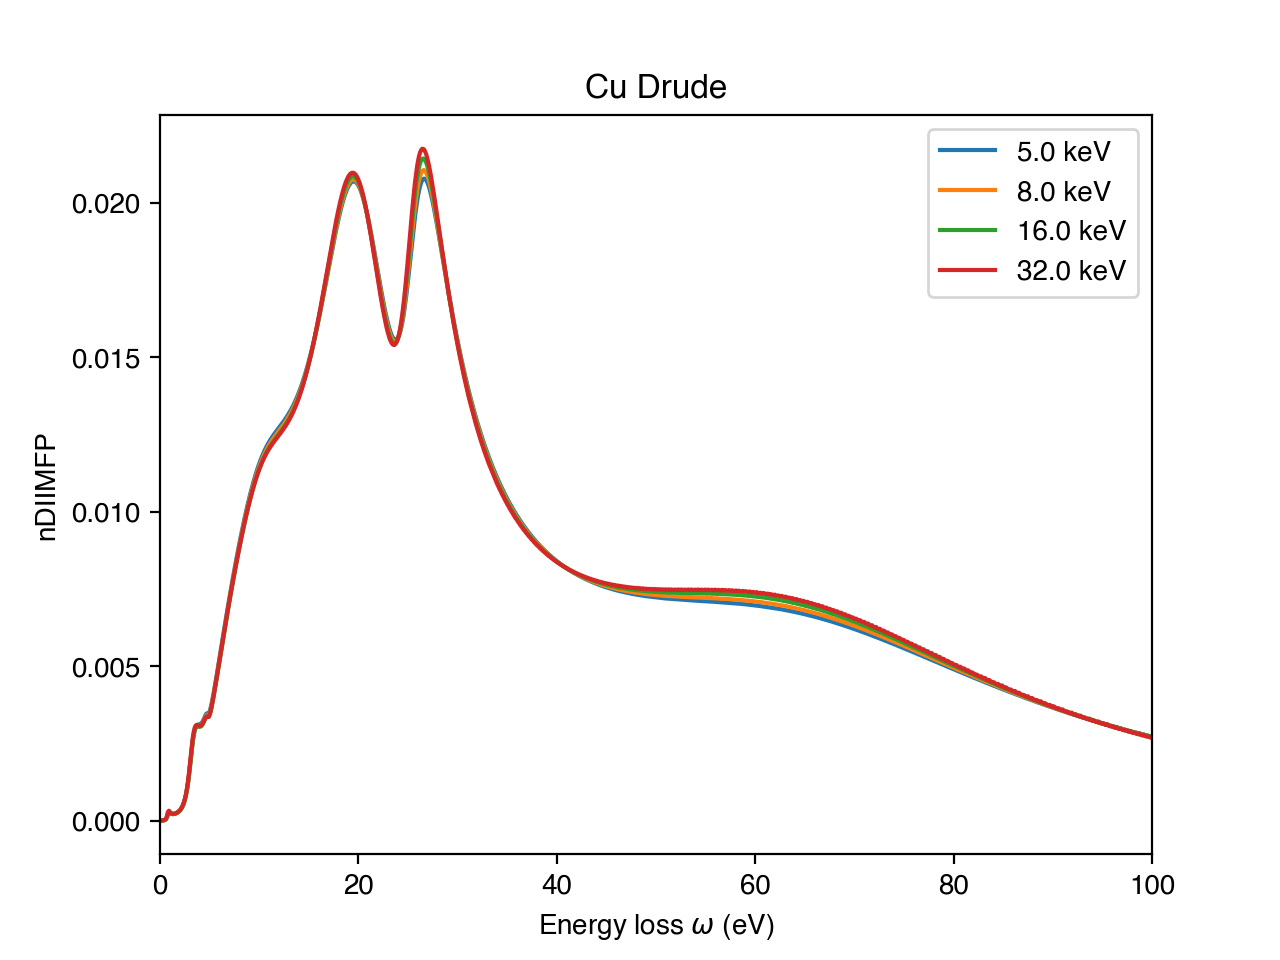

Metal Ef = 8.7
rel_coef 1.014700706979456
Metal Ef = 8.7
rel_coef 1.0235438188918027
Metal Ef = 8.7
rel_coef 1.0472073567140316
Metal Ef = 8.7
rel_coef 1.094882685113485


In [79]:
E = [5000, 8000, 16000, 32000]

plt.figure()

for energy in E:
    cu_drude_lorenz.calculateDIIMFP(energy, 0.1, 15)

    fd = open(f'Cu/cu_{energy}.ndiimfp', 'w')

    for i in range(len(cu_drude_lorenz.DIIMFP_E)):
        fd.write(f'{cu_drude_lorenz.DIIMFP_E[i]:.4f} {cu_drude_lorenz.DIIMFP[i]:.4f}\n')

    plt.plot(cu_drude_lorenz.DIIMFP_E, cu_drude_lorenz.DIIMFP, label=f'{energy/1000} keV')
    

fd.close()
plt.xlim(0, 100)
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('nDIIMFP')
plt.title(f'{cu_drude_lorenz.name} {cu_drude_lorenz.oscillators.model}')
plt.show()
plt.legend()

plt.savefig(f'Cu/{cu_drude_lorenz.name}_{cu_drude_lorenz.oscillators.model}_ndiimfps.png', dpi=600)

**Au**

In [94]:
A = [0.01, 0.02, 0.07, 0.1, 0.07, 0.007, 0.16, 0.15, 0.13, 0.08, 0.02, 0.09, 0.16, 0.02, 0.003, 0.005, 0.008]
gamma = [0.29, 0.81, 3.05, 5.62, 5.04, 2.05, 8.04, 8.56, 10.86, 10.79, 11.13, 5.39, 29.85, 34.51, 38.38, 62.79, 376.54]
omega =[2.62, 3.34, 6.31, 10.58, 17.08, 25.75, 25.39, 33.65, 39.17, 45.72, 52.12, 14.57, 64.21, 96.19, 278.92, 210.69, 470.93]

M = 196.966570 # Molar weight
rho = 19.32 # g/cm3

oscillators = opt.Oscillators('Mermin', A, gamma, omega, alpha = 0)
composition = opt.Composition(['au'], [1])
eloss = opt.linspace(opt.machine_eps,100,0.1)
q = 0.01

au_m = opt.Material('au', oscillators, composition, eloss, q, xraypath)
au_m.Eg = 0
au_m.Ef = 9
au_m.atomic_density = rho * opt.N_Avogadro / M *1e-24
au_m.static_refractive_index = 1.25
au_m.Z = 79
au_m.use_henke_for_ne = True
au_m.use_KK_constraint = False
au_m.use_kk_relation = False

fsum = au_m.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(au_m.Z))

kksum = au_m.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 75.00159991983254
Z = 79
KKSum = 1.1008723805405343


In [18]:
A = [79, 9, 36, 17, 60, 100, 120, 155, 145, 280, 360, 183]
gamma = [0.1, 1, 1.9, 2.3, 4, 9, 10, 6, 7.2, 20, 28, 26]
omega = [0, 3.1, 4.1, 5.3, 8.17, 12, 14, 21.3, 29.5, 38.5, 63, 100]

M = 196.966570 # Molar weight
rho = 19.32 # g/cm3

oscillators = opt.Oscillators('Drude', A, gamma, omega, alpha = 1)
composition = opt.Composition(['au'], [1])
eloss = opt.linspace(opt.machine_eps,100,0.1)
q = 0.01

au_drude = opt.Material('au', oscillators, composition, eloss, q, xraypath)
au_drude.Eg = 0
au_drude.Ef = 9
au_drude.atomic_density = rho * opt.N_Avogadro / M *1e-24
au_drude.static_refractive_index = 1.25
au_drude.Z = 79
au_drude.use_henke_for_ne = True
au_drude.use_KK_constraint = False
au_drude.use_kk_relation = False

fsum = au_drude.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(au_drude.Z))

kksum = au_drude.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 74.32368030191799
Z = 79
KKSum = 1.0100563479664848


In [7]:
# A = [113.1, 44.6, 54.8, 184.9, 728.1, 65.7, 50.0, 74.7, 544.0]
# gamma = [0.2, 1.5, 3.3, 11.8, 71.0, 2.9, 3.9, 13.0, 51.9]
# omega = [0, 4.0, 7.3, 12.8, 18.9, 19.9, 28.9, 38.7, 64.3]

A = [176.571, 13.763, 67.055, 204.804, 561.997, 70.283, 70.122, 84.37, 250.138]
gamma = [0.142, 2.42, 6.258, 22.632, 40.382, 4.391, 6.725, 15.644, 28.832]
omega = [0.014, 5.496, 8.229, 10.93, 19.806, 21.602, 30.852, 41.31, 62.005]
alpha = 0.9939220142827853

M = 196.966570 # Molar weight
rho = 19.32 # g/cm3

oscillators = opt.Oscillators('Drude', A, gamma, omega, alpha = alpha)
composition = opt.Composition(['au'], [1])
eloss = opt.linspace(opt.machine_eps,100,0.1)
q = 0.01

au_drude_lorenz = opt.Material('au', oscillators, composition, eloss, q, xraypath)
au_drude_lorenz.Eg = 0
au_drude_lorenz.Ef = 9
au_drude_lorenz.atomic_density = rho * opt.N_Avogadro / M *1e-24
au_drude_lorenz.static_refractive_index = 1.25
au_drude_lorenz.Z = 79
au_drude_lorenz.use_henke_for_ne = True
au_drude_lorenz.use_KK_constraint = True

fsum = au_drude_lorenz.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(au_drude_lorenz.Z))

kksum = au_drude_lorenz.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 74.30682596390622
Z = 79
KKSum = 1.0165080499372405


Starting optimisation...
Electron density = 1.1626053549814301
found minimum after 1001 evaluations
minimum value =  2.4641696412656133e-05
result code =  5
Starting optimisation...
Electron density = 1.1626053549814301
found minimum after 1000 evaluations
minimum value =  2.5907382003864746e-05
result code =  5
FSum = 74.78580075191609
Z = 79
KKSum = 1.0142139896389892
A = [182.706, 27.912, 62.974, 219.145, 622.929, 76.427, 68.774, 85.088, 257.078]
gamma = [0.12, 8.617, 6.257, 25.607, 48.585, 4.448, 6.483, 15.826, 31.236]
omega = [0.042, 5.371, 7.556, 12.081, 18.339, 21.467, 30.7, 40.84, 63.105]
alpha = 0.9993917213170795


<IPython.core.display.Javascript object>


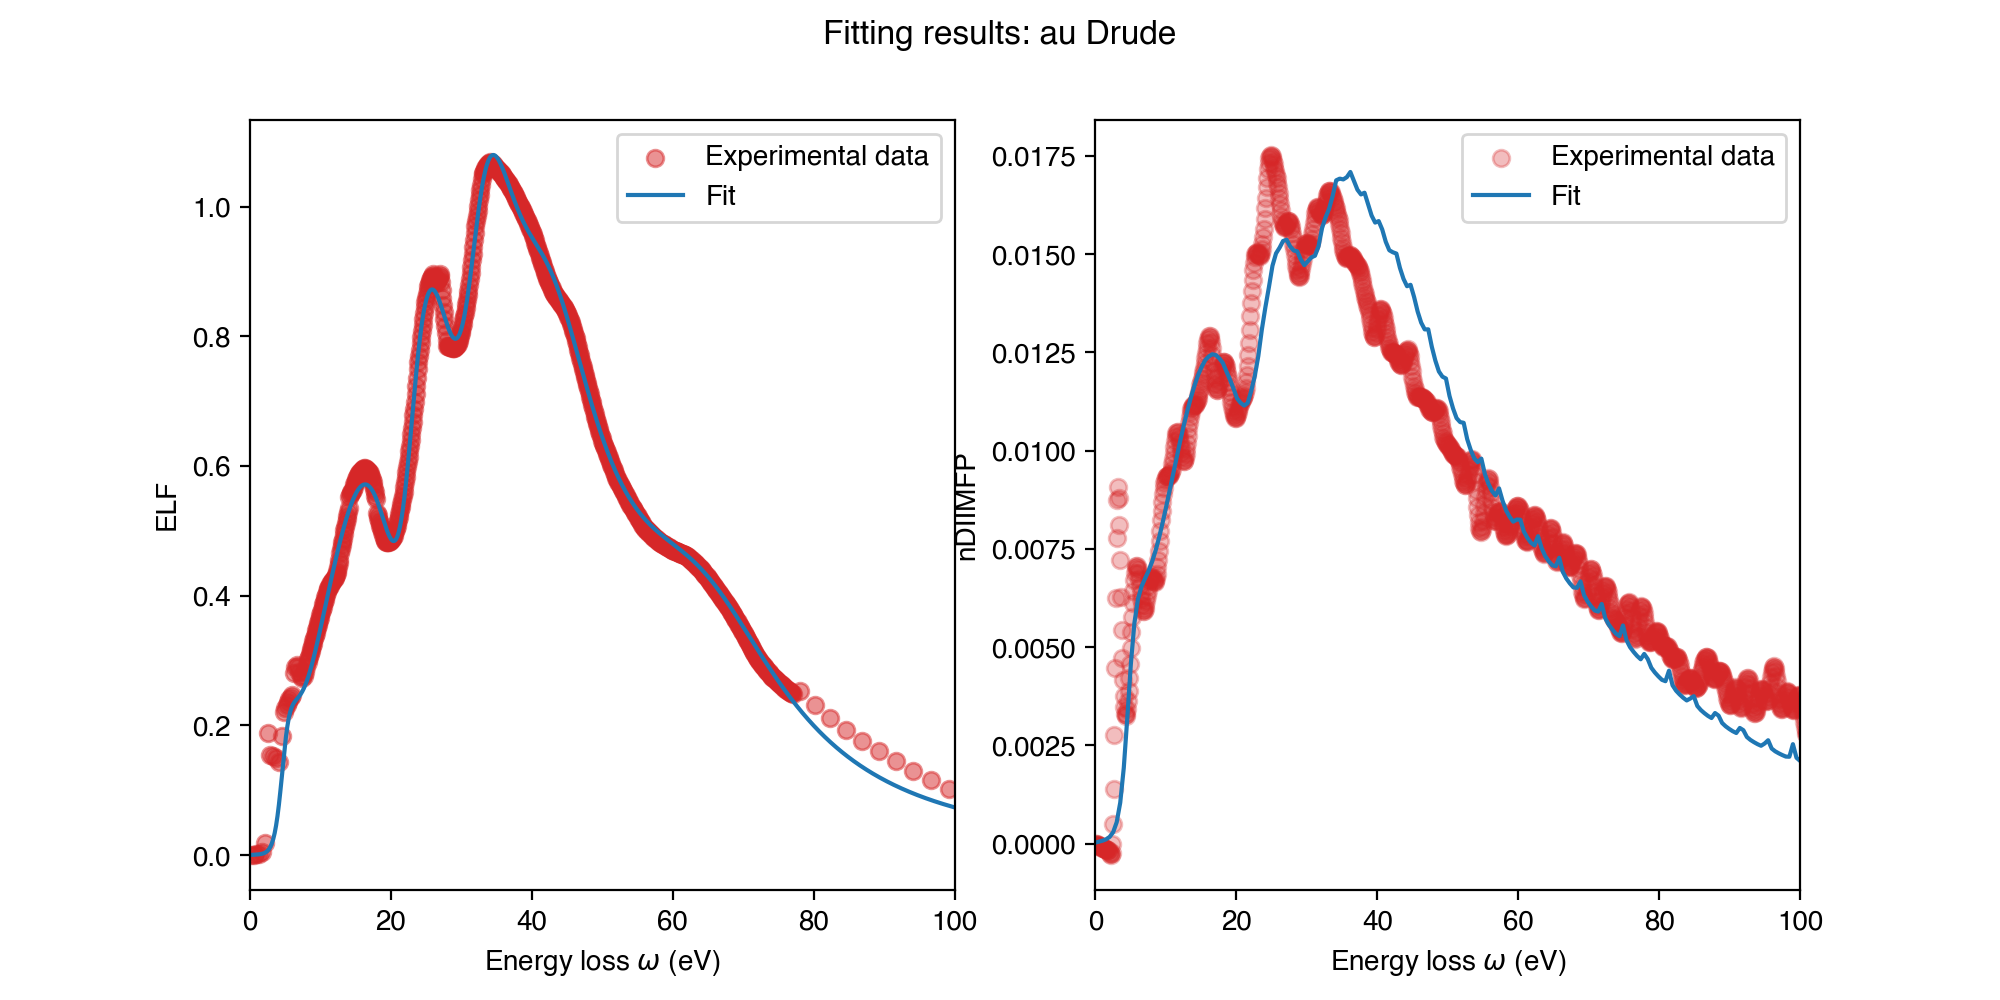

In [8]:
fd = np.loadtxt('/Users/olgaridzel/Research/PHYSDAT/opt/pal/au.diel')
x_exp_elf = fd[:,0]
y_exp_elf = fd[:,3]

exp_data = np.loadtxt('/Users/olgaridzel/Research/olga-optical-data/MATLAB/diimfp/wolga/au.wo', usecols = (0,1,2))
x_exp_ndiimfp = exp_data[:,0]
y_exp_ndiimfp = exp_data[:,1]

exp_data = opt.exp_data()
exp_data.x_elf = x_exp_elf
exp_data.y_elf = y_exp_elf
exp_data.x_ndiimfp = x_exp_ndiimfp
exp_data.y_ndiimfp = y_exp_ndiimfp

E0 = 3400
opt_ = opt.OptFit(au_drude_lorenz, exp_data, E0, n_q = 10)
result = opt_.runOptimisation(0.95, 0.05, maxeval = 1000, xtol_rel = 1e-4, isGlobal = True)
oscOptimised = opt_.vec2Struct(result)

opt_ = opt.OptFit(oscOptimised, exp_data, E0, n_q = 10)
result = opt_.runOptimisation(0.95, 0.05, maxeval = 1000, xtol_rel = 1e-4, isGlobal = False)
oscOptimised = opt_.vec2Struct(result)

fsum = oscOptimised.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluateKKsum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')
print(f'alpha = {oscOptimised.oscillators.alpha}')
# print()
# print(f'osc.A = [{" ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}];')
# print(f'osc.G = [{" ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}];')
# print(f'osc.Om = [{" ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}];')

# oscOptimised = al_drude
oscOptimised.calculateELF()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].scatter(exp_data.x_elf,exp_data.y_elf,label='Experimental data', c='tab:red', alpha = 0.5)
axs[0].plot(oscOptimised.eloss,oscOptimised.ELF,label='Fit')
axs[0].set_xlabel('Energy loss $\omega$ (eV)')
axs[0].set_ylabel('ELF')
axs[0].legend()
axs[0].set_xlim(0,100)

oscOptimised.calculateDIIMFP(1600)
axs[1].scatter(exp_data.x_ndiimfp,exp_data.y_ndiimfp,label='Experimental data', c='tab:red', alpha = 0.3)
axs[1].plot(oscOptimised.DIIMFP_E,oscOptimised.DIIMFP,label='Fit')
axs[1].set_xlabel('Energy loss $\omega$ (eV)')
axs[1].set_ylabel('nDIIMFP')
axs[1].legend()
axs[1].set_xlim(0,100)

fig.suptitle(f'Fitting results: {oscOptimised.name} {oscOptimised.oscillators.model}')
plt.show()

Metal Ef = 9.0
rel_coef 1.009991315125679
Metal Ef = 9.0
rel_coef 1.009991315125679
Metal Ef = 9.0
rel_coef 1.009991315125679


<IPython.core.display.Javascript object>


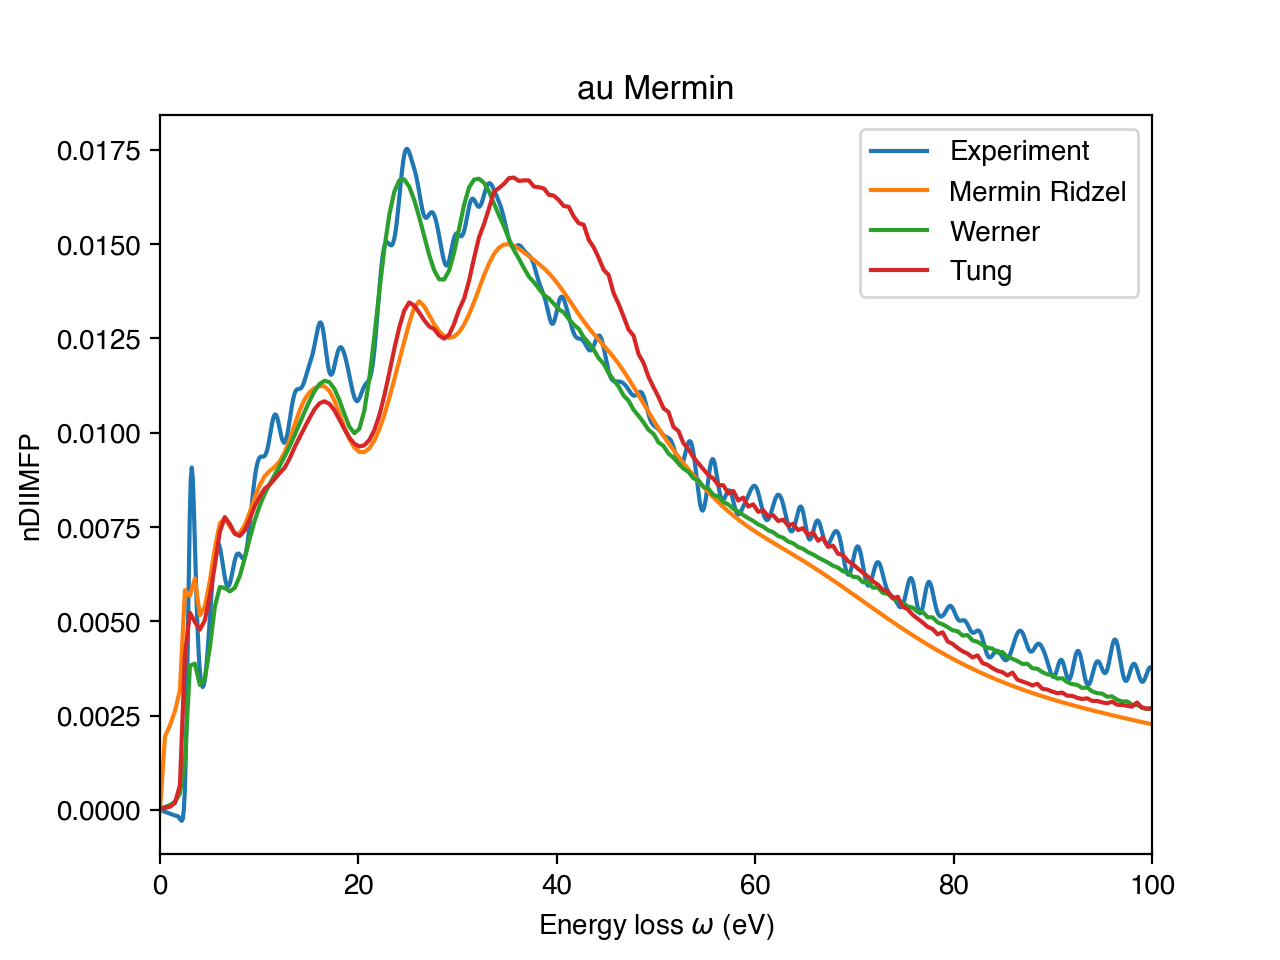

In [97]:
exp_data = np.loadtxt('/Users/olgaridzel/Research/olga-optical-data/MATLAB/diimfp/wolga/au.wo', usecols = (0,1,2))

au_m.calculateDIIMFP(3400, 0.5, 10)
au_drude.calculateDIIMFP(3400, 0.5, 12)
au_drude_lorenz.calculateDIIMFP(3400, 0.5, 12)

plt.figure()
plt.plot(exp_data[:,0], exp_data[:,1], label='Experiment')
plt.plot(au_m.DIIMFP_E,au_m.DIIMFP,label='Mermin Ridzel')
plt.plot(au_drude_lorenz.DIIMFP_E,au_drude_lorenz.DIIMFP,label='Werner')
plt.plot(au_drude.DIIMFP_E,au_drude.DIIMFP,label='Tung')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('nDIIMFP')
plt.title(f'{au_m.name} {au_m.oscillators.model}')
plt.legend()
plt.xlim(0,100)
plt.show()

In [ ]:
E = [5000, 8000, 16000, 32000]

plt.figure()

for energy in E:
    au_m.calculateDIIMFP(energy, 0.1, 13)

    fd = open(f'Au/au_{energy}_m.ndiimfp', 'w')

    for i in range(len(au_m.DIIMFP_E)):
        fd.write(f'{au_m.DIIMFP_E[i]:.4f} {au_m.DIIMFP[i]:.4f}\n')

    plt.plot(au_m.DIIMFP_E, au_m.DIIMFP, label=f'{energy/1000} keV')
    

fd.close()
plt.xlim(0, 100)
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('nDIIMFP')
plt.title(f'{au_m.name} {au_m.oscillators.model}')
plt.show()
plt.legend()

plt.savefig(f'Au/{au_m.name}_{au_m.oscillators.model}_ndiimfps_mermin.png', dpi=600)

<IPython.core.display.Javascript object>


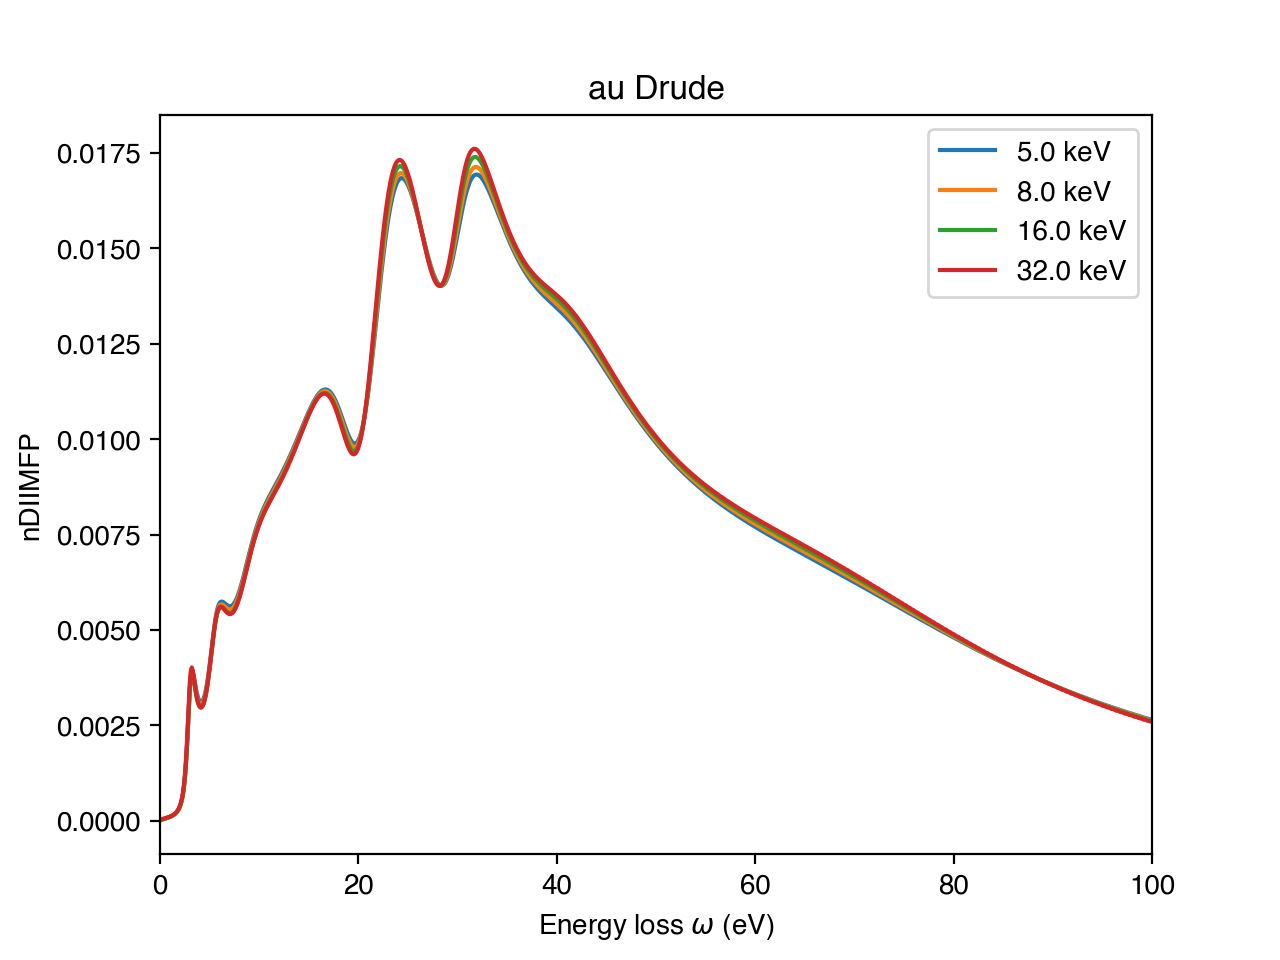

Metal Ef = 9.0
rel_coef 1.014700706979456
Metal Ef = 9.0
rel_coef 1.0235438188918027
Metal Ef = 9.0
rel_coef 1.0472073567140316
Metal Ef = 9.0
rel_coef 1.094882685113485


In [77]:
E = [5000, 8000, 16000, 32000]

plt.figure()

for energy in E:
    au_drude_lorenz.calculateDIIMFP(energy, 0.1, 15)

    fd = open(f'Au/au_{energy}.ndiimfp', 'w')

    for i in range(len(au_drude_lorenz.DIIMFP_E)):
        fd.write(f'{au_drude_lorenz.DIIMFP_E[i]:.4f} {au_drude_lorenz.DIIMFP[i]:.4f}\n')

    plt.plot(au_drude_lorenz.DIIMFP_E, au_drude_lorenz.DIIMFP, label=f'{energy/1000} keV')
    

fd.close()
plt.xlim(0, 100)
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('nDIIMFP')
plt.title(f'{au_drude_lorenz.name} {au_drude_lorenz.oscillators.model}')
plt.show()
plt.legend()

plt.savefig(f'Au/{au_drude_lorenz.name}_{au_drude_lorenz.oscillators.model}_ndiimfps_drude.png', dpi=600)

**Ag**

In [61]:
A = [0.05, 0.19, 0.05, 0.09, 0.11, 0.04, 0.07, 0.22, 0.07, 0.14, 0.04, 0.09, 0.01]
gamma = [0.16, 2.83, 4.1, 13.99, 6.45, 1.31, 11.06, 9.79, 9.91, 10.06, 15.08, 16.95, 13.19]
omega =[3.82, 7.91, 11.36, 56.91, 17.32, 4.96, 48.34, 26.26, 41.68, 35.01, 81.47, 70, 91.37]

M = 107.8682 # Molar weight
rho = 10.5 # g/cm3

oscillators = opt.Oscillators('Mermin', A, gamma, omega, alpha = 0)
composition = opt.Composition(['ag'], [1])
eloss = opt.linspace(opt.machine_eps,100,0.1)
q = 0.01

ag_m = opt.Material('ag', oscillators, composition, eloss, q, xraypath)
ag_m.Eg = 0
ag_m.Ef = 7.2
ag_m.atomic_density = rho * opt.N_Avogadro / M *1e-24
ag_m.static_refractive_index = 1.21
ag_m.Z = 47
ag_m.use_henke_for_ne = True
ag_m.use_KK_constraint = False
ag_m.use_kk_relation = False

fsum = ag_m.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(ag_m.Z))

kksum = ag_m.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 50.08906573833612
Z = 47
KKSum = 1.1746692268605372


In [9]:
A = [98.4, 103.9, 23.8, 318.3, 89.6, 63.5, 43.3, 313.3, 519.9]
gamma = [0.065, 93.8, 0.7, 22, 6.3, 3.3, 3.7, 16.7, 38.8]
omega = [0, 1, 4.9, 10.3, 13.2, 21.2, 30.2, 43, 65.7]
alpha = 1

M = 107.8682 # Molar weight
rho = 10.5 # g/cm3

oscillators = opt.Oscillators('Drude', A, gamma, omega, alpha = alpha)
composition = opt.Composition(['ag'], [1])
eloss = opt.linspace(opt.machine_eps,100,0.1)
q = 0.01

ag_drude_lorenz = opt.Material('ag', oscillators, composition, eloss, q, xraypath)
ag_drude_lorenz.Eg = 0
ag_drude_lorenz.Ef = 7.2
ag_drude_lorenz.atomic_density = rho * opt.N_Avogadro / M *1e-24
ag_drude_lorenz.static_refractive_index = 1.21
ag_drude_lorenz.Z = 47
ag_drude_lorenz.use_henke_for_ne = True
ag_drude_lorenz.use_KK_constraint = False
ag_drude_lorenz.use_kk_relation = False

fsum = ag_drude_lorenz.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(ag_drude_lorenz.Z))

kksum = ag_drude_lorenz.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 46.49871731620581
Z = 47
KKSum = 1.0009415729486868


Starting optimisation...
Electron density = 0.9165540456881278
found minimum after 5000 evaluations
minimum value =  0.0004877631930081395
result code =  5
FSum = 44.649095672128695
Z = 47
KKSum = 1.0072001194800475
A = [83.241, 81.996, 31.262, 227.247, 104.982, 102.327, 67.771, 287.638, 277.36]
gamma = [0.066, 99.586, 0.431, 16.058, 6.427, 6.145, 6.868, 19.077, 24.626]
omega = [0.28, 0.942, 5.164, 13.205, 16.713, 23.264, 31.572, 42.11, 59.934]
alpha = 0.9315632021267268


<IPython.core.display.Javascript object>


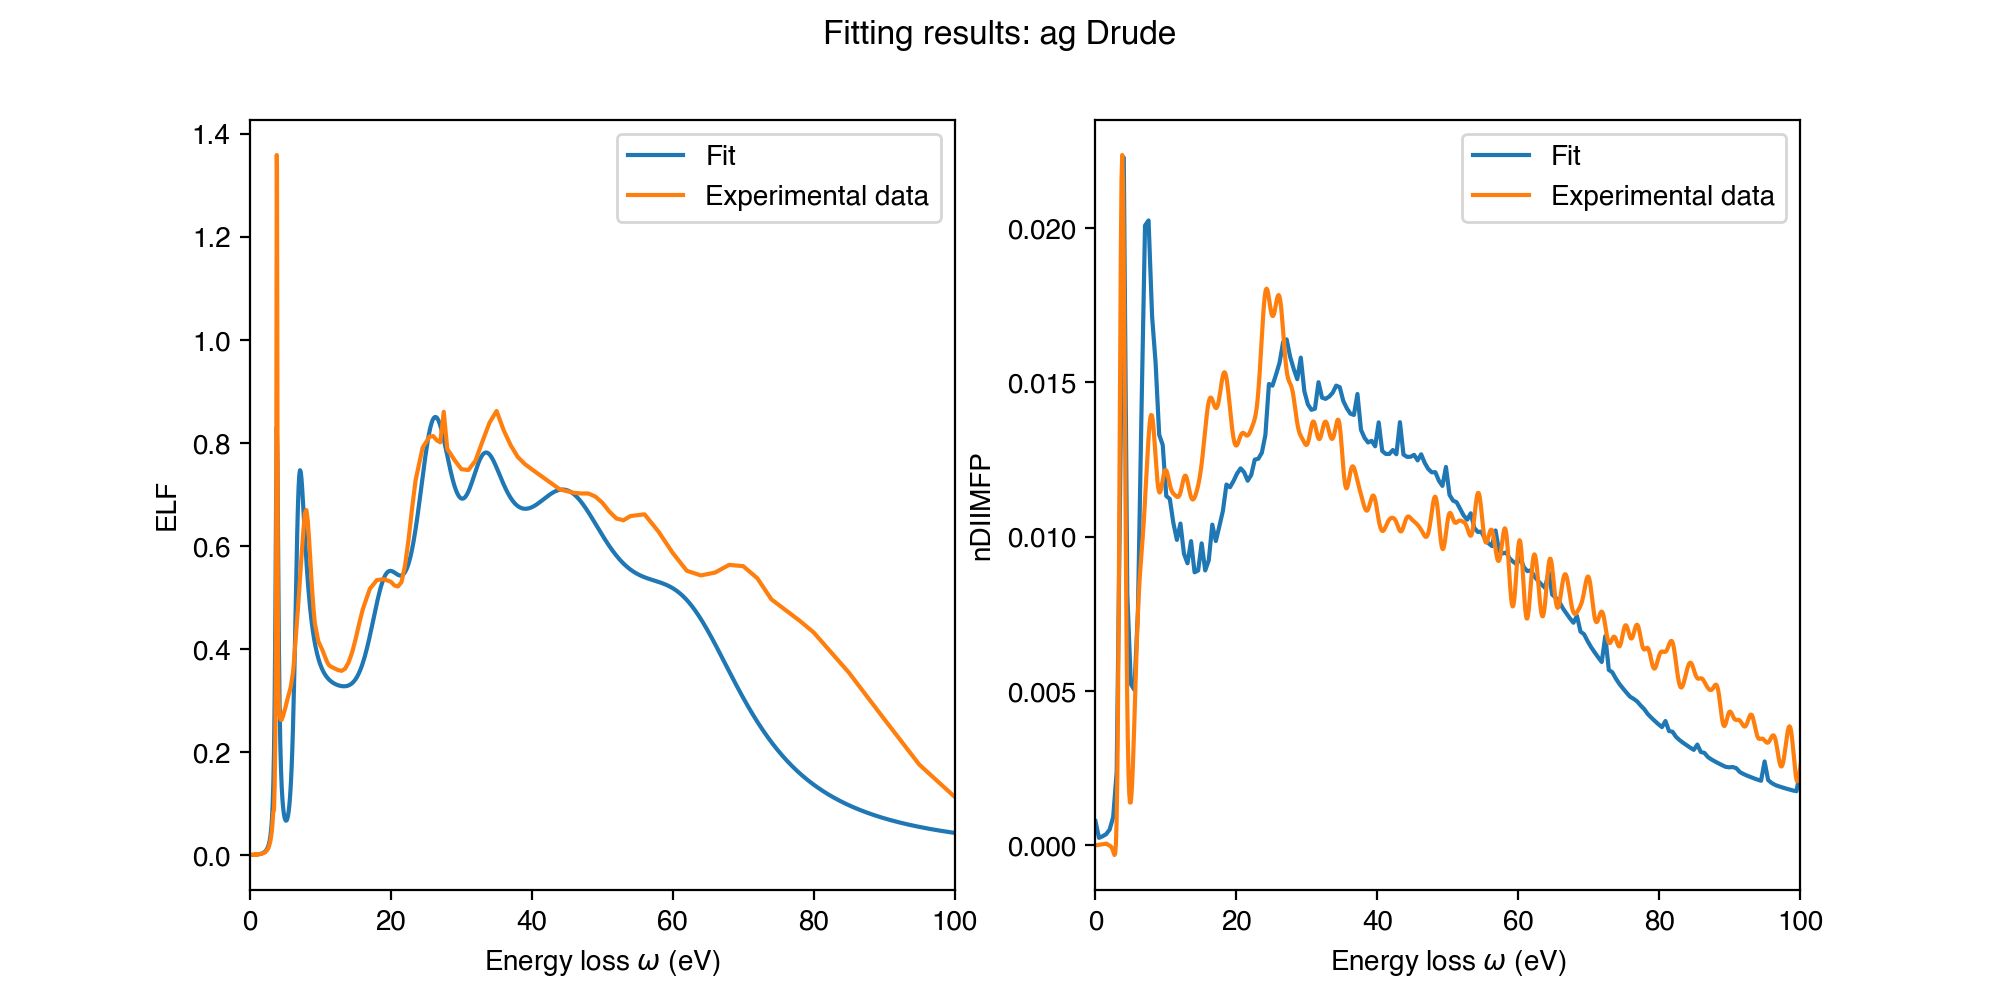

In [11]:
fd = np.loadtxt('/Users/olgaridzel/Research/PHYSDAT/opt/pal/ag.diel')
x_exp_elf = fd[:,0]
y_exp_elf = fd[:,3]

exp_data = np.loadtxt('/Users/olgaridzel/Research/olga-optical-data/MATLAB/diimfp/wolga/ag.wo', usecols = (0,1,2))
x_exp_ndiimfp = exp_data[:,0]
y_exp_ndiimfp = exp_data[:,1]

exp_data = opt.exp_data()
exp_data.x_elf = x_exp_elf
exp_data.y_elf = y_exp_elf
exp_data.x_ndiimfp = x_exp_ndiimfp
exp_data.y_ndiimfp = y_exp_ndiimfp

opt_ = opt.OptFit(ag_drude_lorenz, exp_data, 3400, n_q = 10)
result = opt_.runOptimisation(0.7, 0.3, maxeval = 5000, xtol_rel = 1e-4)
oscOptimised = opt_.vec2Struct(result)

fsum = oscOptimised.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluateKKsum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')
print(f'alpha = {oscOptimised.oscillators.alpha}')
# print()
# print(f'osc.A = [{" ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}];')
# print(f'osc.G = [{" ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}];')
# print(f'osc.Om = [{" ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}];')

oscOptimised.calculateELF()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(oscOptimised.eloss,oscOptimised.ELF,label='Fit')
axs[0].plot(exp_data.x_elf,exp_data.y_elf,label='Experimental data')
axs[0].set_xlabel('Energy loss $\omega$ (eV)')
axs[0].set_ylabel('ELF')
axs[0].legend()
axs[0].set_xlim(0,100)

oscOptimised.calculateDIIMFP(3400)
axs[1].plot(oscOptimised.DIIMFP_E,oscOptimised.DIIMFP,label='Fit')
axs[1].plot(exp_data.x_ndiimfp,exp_data.y_ndiimfp,label='Experimental data')
axs[1].set_xlabel('Energy loss $\omega$ (eV)')
axs[1].set_ylabel('nDIIMFP')
axs[1].legend()
axs[1].set_xlim(0,100)

fig.suptitle(f'Fitting results: {oscOptimised.name} {oscOptimised.oscillators.model}')
plt.show()

Metal Ef = 7.2
rel_coef 1.009991315125679
Metal Ef = 7.2
rel_coef 1.009991315125679


<IPython.core.display.Javascript object>


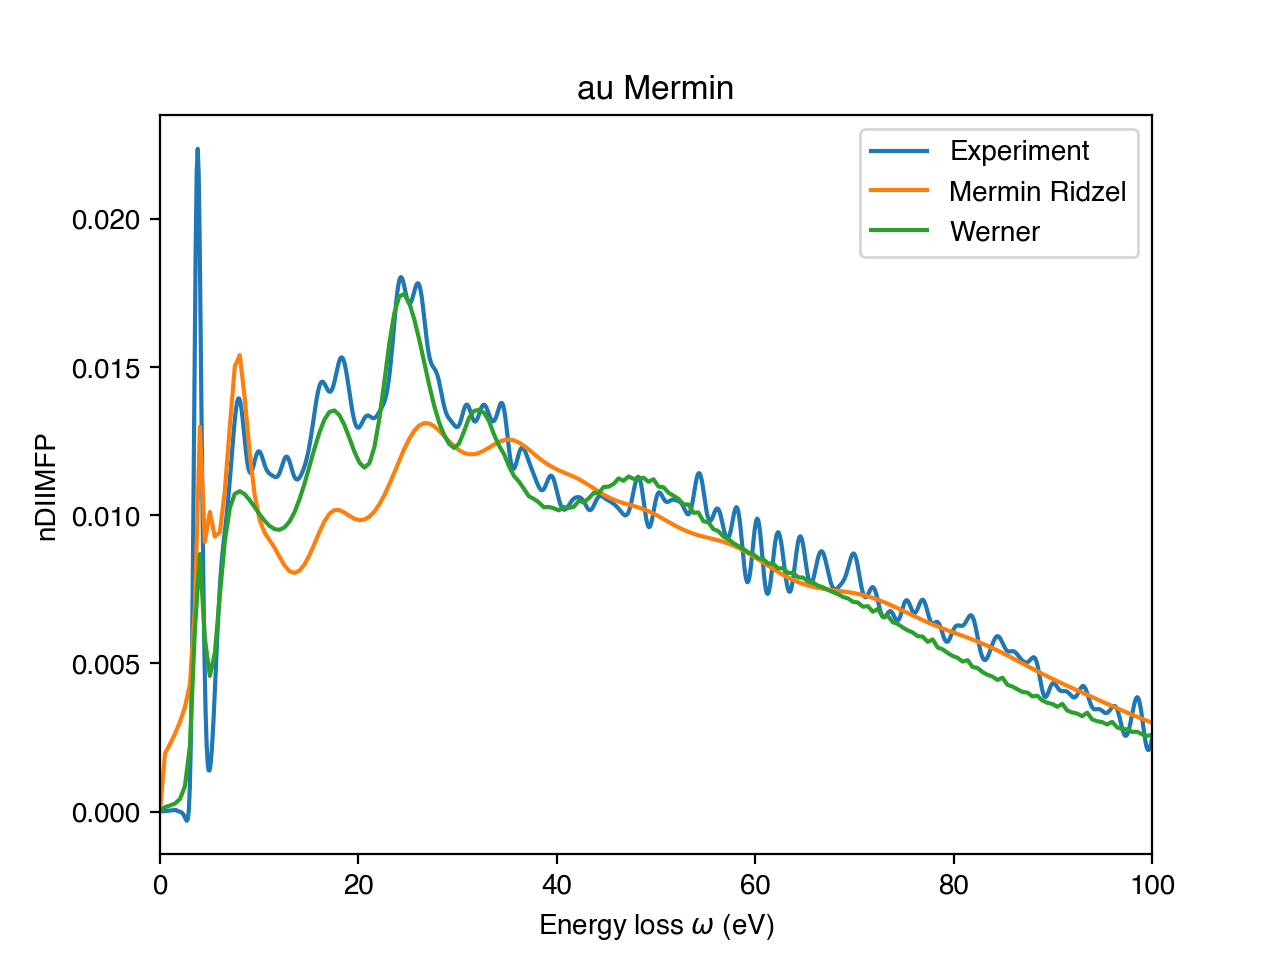

In [92]:
exp_data = np.loadtxt('/Users/olgaridzel/Research/olga-optical-data/MATLAB/diimfp/wolga/ag.wo', usecols = (0,1,2))

ag_m.calculateDIIMFP(3400, 0.5, 10)
# ag_drude.calculateDIIMFP(3400, 0.5, 12)
ag_drude_lorenz.calculateDIIMFP(3400, 0.5, 12)

plt.figure()
plt.plot(exp_data[:,0], exp_data[:,1], label='Experiment')
plt.plot(ag_m.DIIMFP_E,ag_m.DIIMFP,label='Mermin Ridzel')
plt.plot(ag_drude_lorenz.DIIMFP_E,ag_drude_lorenz.DIIMFP,label='Werner')
# plt.plot(ag_drude.DIIMFP_E,ag_drude.DIIMFP,label='Tung')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('nDIIMFP')
plt.title(f'{ag_m.name} {ag_m.oscillators.model}')
plt.legend()
plt.xlim(0,100)
plt.show()

<IPython.core.display.Javascript object>


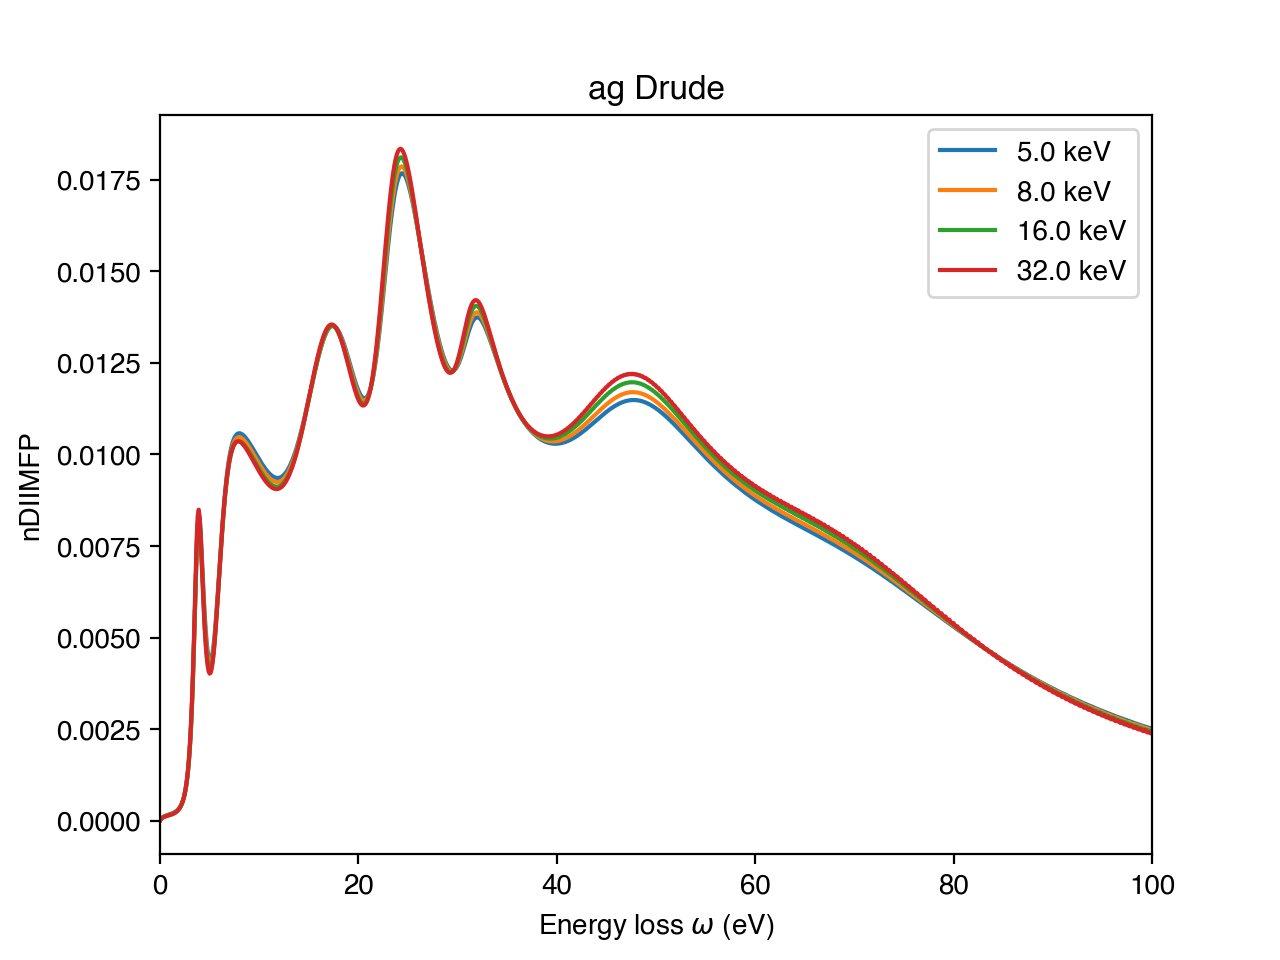

Metal Ef = 7.2
rel_coef 1.014700706979456
Metal Ef = 7.2
rel_coef 1.0235438188918027
Metal Ef = 7.2
rel_coef 1.0472073567140316
Metal Ef = 7.2
rel_coef 1.094882685113485


In [71]:
E = [5000, 8000, 16000, 32000]

plt.figure()

for energy in E:
    ag_drude_lorenz.calculateDIIMFP(energy, 0.1, 15)

    fd = open(f'Ag/ag_{energy}.ndiimfp', 'w')

    for i in range(len(ag_drude_lorenz.DIIMFP_E)):
        fd.write(f'{ag_drude_lorenz.DIIMFP_E[i]:.4f} {ag_drude_lorenz.DIIMFP[i]:.4f}\n')

    plt.plot(ag_drude_lorenz.DIIMFP_E, ag_drude_lorenz.DIIMFP, label=f'{energy/1000} keV')
    

fd.close()
plt.xlim(0, 100)
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('nDIIMFP')
plt.title(f'{ag_drude_lorenz.name} {ag_drude_lorenz.oscillators.model}')
plt.show()
plt.legend()

plt.savefig(f'Ag/{ag_drude_lorenz.name}_{ag_drude_lorenz.oscillators.model}_ndiimfps.png', dpi=600)

**W**

In [98]:
A = [0.01, 0.006, 0.006, 0.003, 0.007, 0.04, 0.06, 0.003, 0.09, 0.45, 0.04, 0.11, 0.25, 0.04]
gamma = [0.53, 0.76, 0.81, 0.57, 1.03, 2.33, 4.04, 0.14, 8.93, 6.58, 6.55, 8.14, 25.15, 194.48]
omega = [1.37, 2.14, 2.86, 3.92, 8.66, 10.07, 14.95, 0.87, 31.52, 25.48, 37.63, 42.68, 56.47, 188.48]

M = 183.85 # Molar weight
rho = 19.3 # g/cm3

oscillators = opt.Oscillators('Mermin', A, gamma, omega, alpha = 0)
composition = opt.Composition(['w'], [1])
eloss = opt.linspace(opt.machine_eps,100,0.1)
q = 0.01

w_m = opt.Material('w', oscillators, composition, eloss, q, xraypath)
w_m.Eg = 0
w_m.Ef = 10.1
w_m.atomic_density = rho * opt.N_Avogadro / M *1e-24
w_m.static_refractive_index = 1.24
w_m.Z = 74
w_m.use_henke_for_ne = True
w_m.use_KK_constraint = False
w_m.use_kk_relation = False

fsum = w_m.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(w_m.Z))

kksum = w_m.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 72.8554343356933
Z = 74
KKSum = 1.1216073496424785


In [9]:
A = [168, 54.3, 47.4, 25.5, 33.4, 37.9, 164.2, 125.1, 2.9, 98.4, 11.1, 221.9, 495.5]
gamma = [0.027, 0.5, 0.9, 0.5, 0.8, 2.5, 6, 7.7, 0.6, 3.1, 0.9, 8.9, 65.1]
omega = [0, 1, 2.7, 3.9, 5, 7, 11.1, 16.7, 22.9, 38.4, 41.1, 48.5, 80.2]

M = 183.85 # Molar weight
rho = 19.3 # g/cm3

oscillators = opt.Oscillators('Drude', A, gamma, omega, alpha = 1)
composition = opt.Composition(['w'], [1])
eloss = opt.linspace(opt.machine_eps,100,0.1)
q = 0

w_drude_lorenz = opt.Material('w', oscillators, composition, eloss, q, xraypath)
w_drude_lorenz.Eg = 0
w_drude_lorenz.Ef = 10.1
w_drude_lorenz.atomic_density = rho * opt.N_Avogadro / M *1e-24
w_drude_lorenz.static_refractive_index = 1.24
w_drude_lorenz.Z = 74
w_drude_lorenz.use_henke_for_ne = True
w_drude_lorenz.use_KK_constraint = False
w_drude_lorenz.use_kk_relation = False

fsum = w_drude_lorenz.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(w_drude_lorenz.Z))

kksum = w_drude_lorenz.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 70.91210998394797
Z = 74
KKSum = 1.0246782992399084


Starting optimisation...
Electron density = 1.0256563053138608
FSum = 71.50518227377997
Z = 74
KKSum = 1.0310309195795915
A = [149.616, 77.852, 62.169, 23.105, 45.223, 29.861, 255.427, 185.871, 3.037, 152.487, 16.379, 189.276, 222.64]
gamma = [0.029, 0.79, 1.489, 0.746, 1.459, 4.116, 10.289, 13.651, 1.188, 6.149, 1.532, 14.062, 90.509]
omega = [0.082, 1.01, 2.693, 3.859, 5.053, 6.145, 12.165, 13.886, 44.55, 37.571, 70.93, 49.874, 73.604]
alpha = 0.8650955388531374


<IPython.core.display.Javascript object>


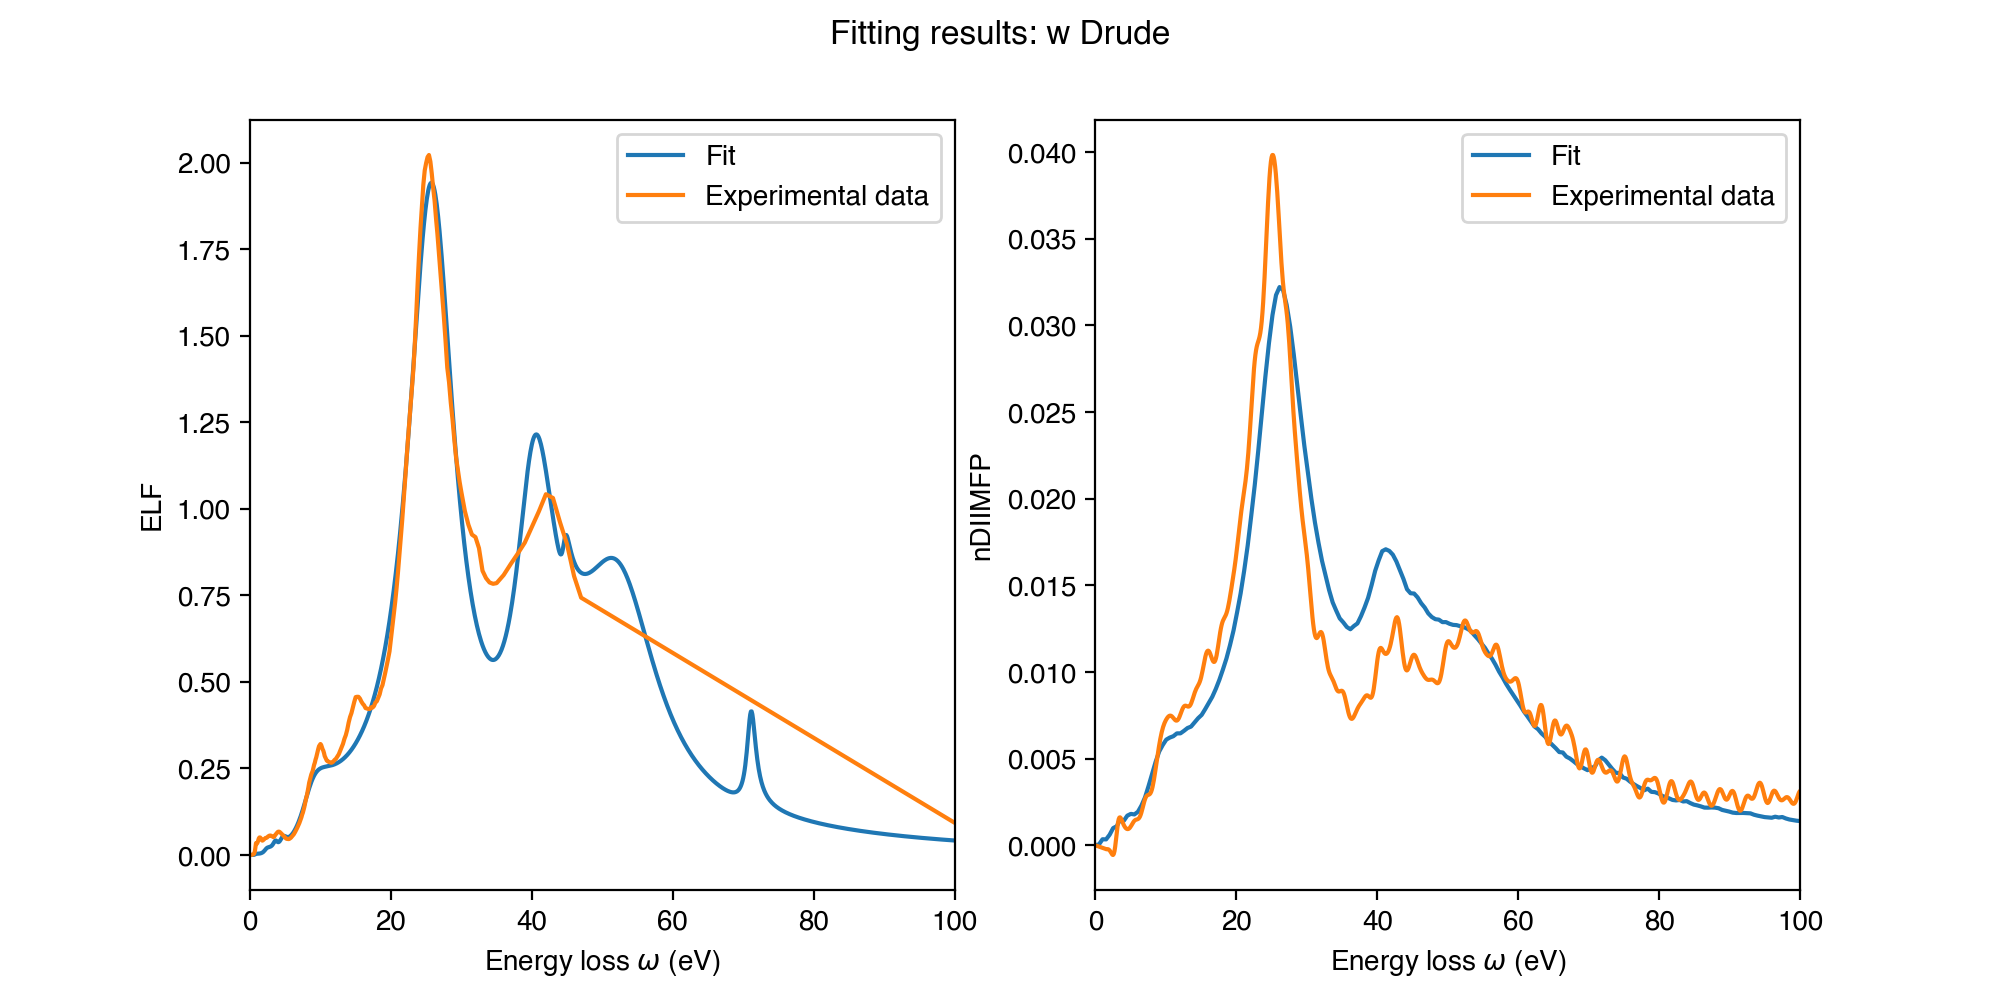

In [10]:
fd = np.loadtxt('/Users/olgaridzel/Research/PHYSDAT/opt/pal/w.diel')
x_exp_elf = fd[:,0]
y_exp_elf = fd[:,3]

exp_data = np.loadtxt('/Users/olgaridzel/Research/olga-optical-data/MATLAB/diimfp/wolga/w.wo', usecols = (0,1,2))
x_exp_ndiimfp = exp_data[:,0]
y_exp_ndiimfp = exp_data[:,1]

exp_data = opt.exp_data()
exp_data.x_elf = x_exp_elf
exp_data.y_elf = y_exp_elf
exp_data.x_ndiimfp = x_exp_ndiimfp
exp_data.y_ndiimfp = y_exp_ndiimfp

opt_ = opt.OptFit(w_drude_lorenz, exp_data, 3400, n_q = 10)
result = opt_.runOptimisation('elf+ndiimfp', maxeval = 1000, xtol_rel = 1e-4)
oscOptimised = opt_.vec2Struct(result)

fsum = oscOptimised.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluateKKsum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')
print(f'alpha = {oscOptimised.oscillators.alpha}')
# print()
# print(f'osc.A = [{" ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}];')
# print(f'osc.G = [{" ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}];')
# print(f'osc.Om = [{" ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}];')

# oscOptimised = al_drude
oscOptimised.calculateELF()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(oscOptimised.eloss,oscOptimised.ELF,label='Fit')
axs[0].plot(exp_data.x_elf,exp_data.y_elf,label='Experimental data')
axs[0].set_xlabel('Energy loss $\omega$ (eV)')
axs[0].set_ylabel('ELF')
axs[0].legend()
axs[0].set_xlim(0,100)

oscOptimised.calculateDIIMFP(3400)
axs[1].plot(oscOptimised.DIIMFP_E,oscOptimised.DIIMFP,label='Fit')
axs[1].plot(exp_data.x_ndiimfp,exp_data.y_ndiimfp,label='Experimental data')
axs[1].set_xlabel('Energy loss $\omega$ (eV)')
axs[1].set_ylabel('nDIIMFP')
axs[1].legend()
axs[1].set_xlim(0,100)

fig.suptitle(f'Fitting results: {oscOptimised.name} {oscOptimised.oscillators.model}')
plt.show()

Metal Ef = 10.1
rel_coef 1.009991315125679
Metal Ef = 10.1
rel_coef 1.009991315125679


<IPython.core.display.Javascript object>


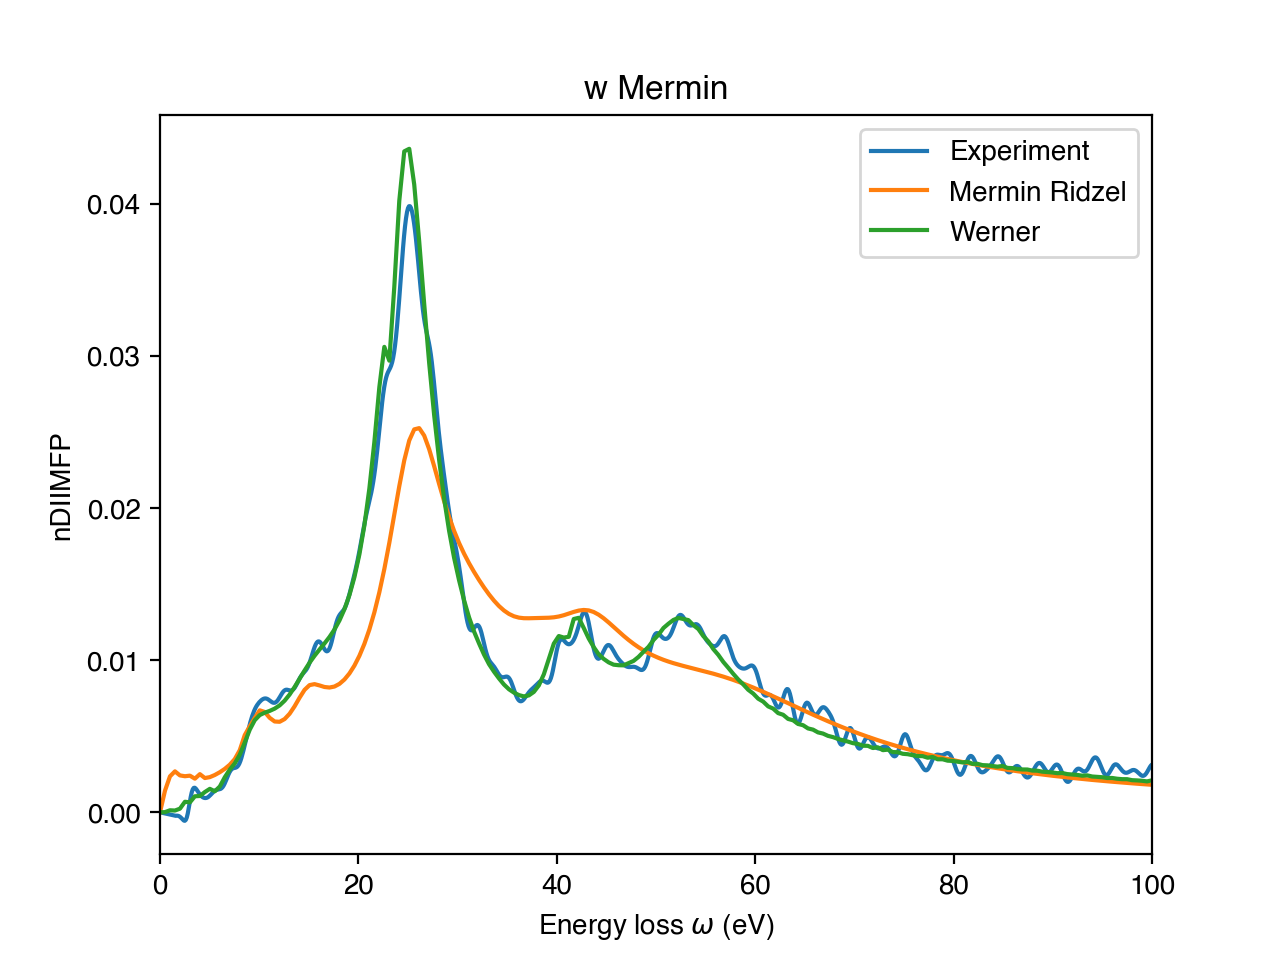

In [100]:
exp_data = np.loadtxt('/Users/olgaridzel/Research/olga-optical-data/MATLAB/diimfp/wolga/w.wo', usecols = (0,1,2))

w_m.calculateDIIMFP(3400, 0.5, 10)
# w_drude.calculateDIIMFP(3400, 0.5, 12)
w_drude_lorenz.calculateDIIMFP(3400, 0.5, 12)

plt.figure()
plt.plot(exp_data[:,0], exp_data[:,1], label="Experiment")
plt.plot(w_m.DIIMFP_E,w_m.DIIMFP,label='Mermin Ridzel')
plt.plot(w_drude_lorenz.DIIMFP_E,w_drude_lorenz.DIIMFP,label='Werner')
# plt.plot(w_drude.DIIMFP_E,w_drude.DIIMFP,label='Tung')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('nDIIMFP')
plt.title(f'{w_m.name} {w_m.oscillators.model}')
plt.legend()
plt.xlim(0,100)
plt.show()

<IPython.core.display.Javascript object>


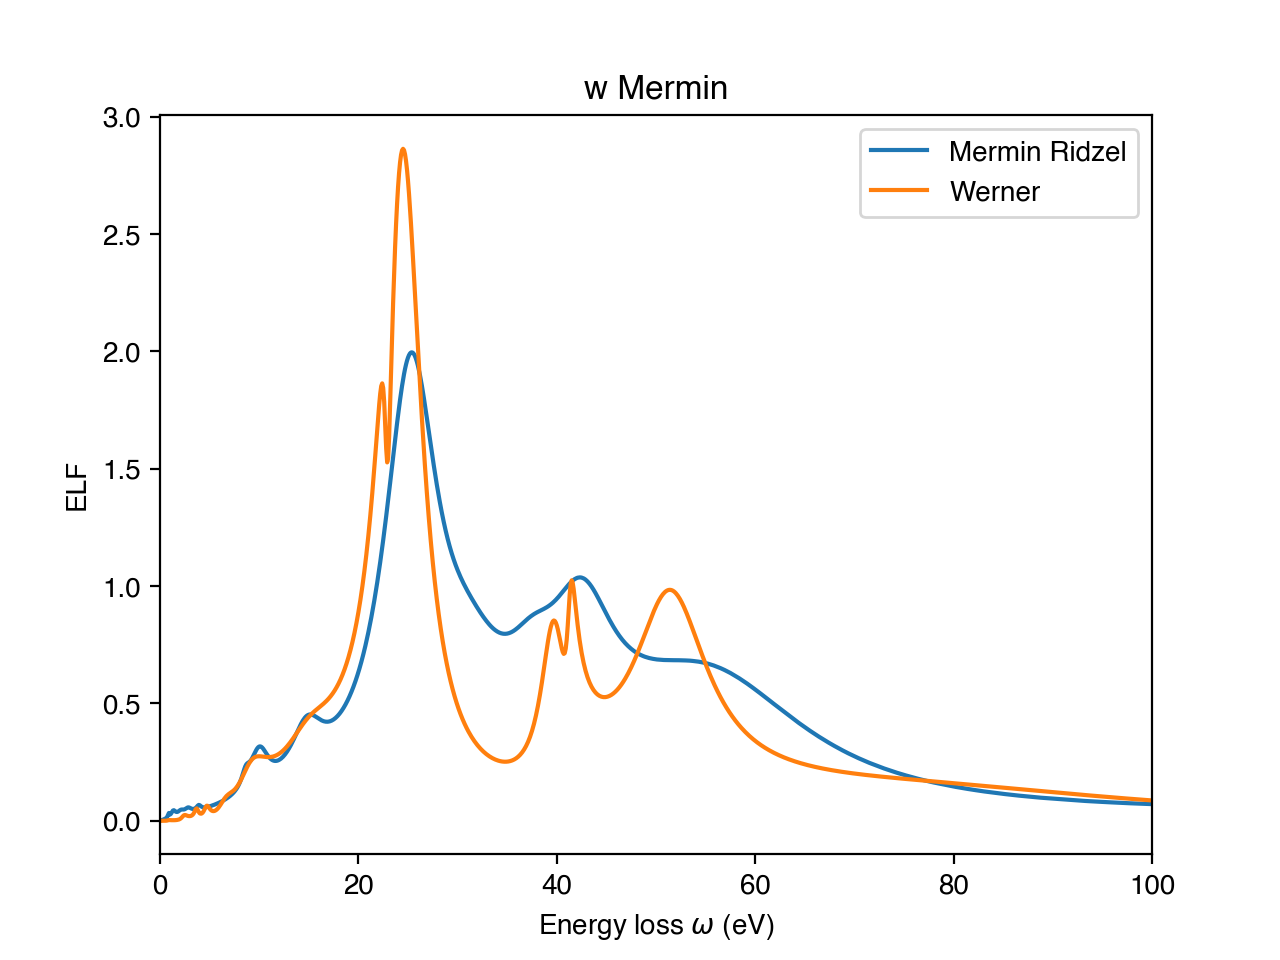

In [58]:
w_m.calculateELF()
w_drude_lorenz.calculateELF()

plt.figure()
plt.plot(w_m.eloss,w_m.ELF,label='Mermin Ridzel')
plt.plot(w_drude_lorenz.eloss,w_drude_lorenz.ELF,label='Werner')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('ELF')
plt.title(f'{w_m.name} {w_m.oscillators.model}')
plt.legend()
plt.xlim(0,100)
plt.show()

<IPython.core.display.Javascript object>


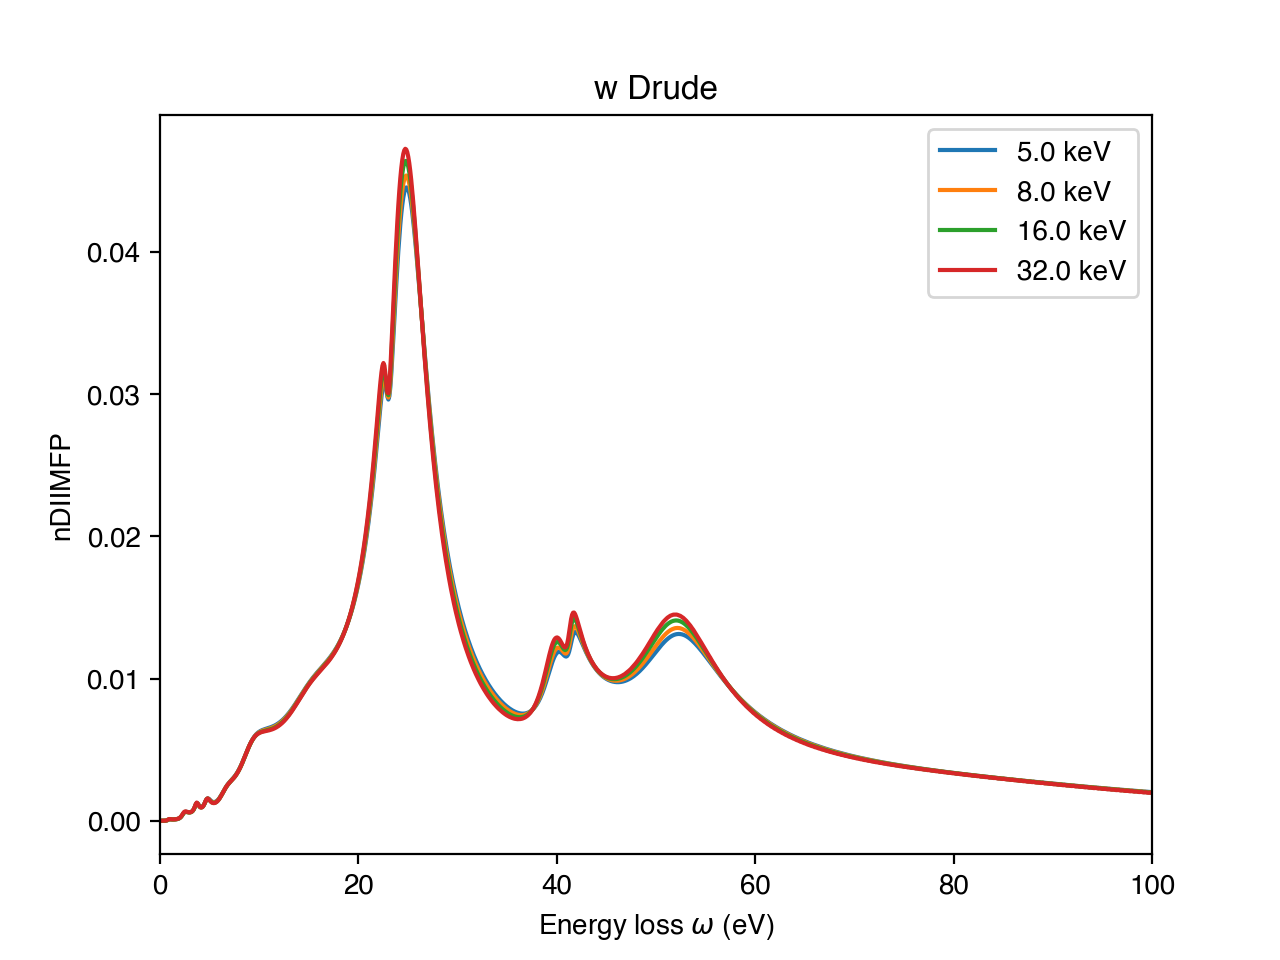

Metal Ef = 10.1
rel_coef 1.014700706979456
Metal Ef = 10.1
rel_coef 1.0235438188918027
Metal Ef = 10.1
rel_coef 1.0472073567140316
Metal Ef = 10.1
rel_coef 1.094882685113485


In [70]:
E = [5000, 8000, 16000, 32000]

plt.figure()

for energy in E:
    w_drude_lorenz.calculateDIIMFP(energy, 0.1, 15)

    fd = open(f'W/w_{energy}.ndiimfp', 'w')

    for i in range(len(w_drude_lorenz.DIIMFP_E)):
        fd.write(f'{w_drude_lorenz.DIIMFP_E[i]:.4f} {w_drude_lorenz.DIIMFP[i]:.4f}\n')

    plt.plot(w_drude_lorenz.DIIMFP_E, w_drude_lorenz.DIIMFP, label=f'{energy/1000} keV')
    

fd.close()
plt.xlim(0, 100)
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('nDIIMFP')
plt.title(f'{w_drude_lorenz.name} {w_drude_lorenz.oscillators.model}')
plt.show()
plt.legend()

plt.savefig(f'W/{w_drude_lorenz.name}_{w_drude_lorenz.oscillators.model}_ndiimfps.png', dpi=600)

In [9]:
x1 = [0, 2, 3]
x3 = [4, 5, 6]
x2 = 4

x = np.append( np.hstack((x1,x3)), x2)
print(x)

[0 2 3 4 5 6 4]


In [10]:
x[-1]

4